# Importy

In [1]:
import sys
sys.path.insert(0, "/home/krzysiek/Development/claim-modelling-kedro/claim_modelling_kedro/src")

import logging

logger = logging.getLogger(__name__)
logger.setLevel("INFO")

In [2]:
import os
import mlflow
import logging
import time
import tempfile
from abc import ABC, abstractmethod
from datetime import timedelta
from typing import Any, Dict, Union, List, Tuple, Optional
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np


logger = logging.getLogger(__name__)

In [3]:
# !pip install git+https://github.com/krzpiesiewicz/timeseries

In [4]:
from timeseries import Interval, plot_ts
from timeseries.plotting import plot_hist, plot_stats

In [5]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("test")
run = mlflow.start_run(run_name="dev_run")

In [6]:
# from claim_modelling_kedro.pipelines.utils.utils import (
from claim_modelling_kedro.pipelines.utils.dataframes import (
    load_metrics_table_from_mlflow,
    load_predictions_and_target_from_mlflow,
    load_metrics_cv_stats_from_mlflow,
)
from claim_modelling_kedro.pipelines.utils.datasets import (
    get_partition,
    get_mlflow_run_id_for_partition,
)

In [8]:
# Step 1: Sort the target_df by stratify_target_col in descending order
t = np.hstack((np.arange(101,110,1), np.array([100] * 15 + [50] * 20), np.arange(0, 20, 1)))
t = np.sort(t)[::-1]
t

array([109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,  50,  50,
        50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,
        50,  50,  50,  50,  50,  19,  18,  17,  16,  15,  14,  13,  12,
        11,  10,   9,   8,   7,   6,   5,   4,   3,   2,   1,   0])

In [19]:
# Step 2: Label the sorted samples in a round-robin manner
n_samples = t.shape[0]
cv_folds = 5
fold_labels = np.tile(np.arange(cv_folds), n_samples // cv_folds + 1)[:n_samples]

random_seed = 1
rng = np.random.default_rng(random_seed)
for i in range(0, n_samples, cv_folds):
    rng.shuffle(fold_labels[i : min(i + cv_folds, n_samples)])
fold_labels

array([4, 0, 1, 2, 3, 3, 0, 1, 4, 2, 2, 3, 4, 1, 0, 1, 3, 4, 0, 2, 3, 0,
       1, 4, 2, 1, 3, 0, 2, 4, 4, 3, 1, 0, 2, 0, 2, 1, 3, 4, 3, 1, 2, 0,
       4, 2, 0, 3, 4, 1, 1, 3, 2, 4, 0, 3, 4, 1, 0, 2, 0, 3, 2, 1])

In [28]:
np.linspace(0, len(t), cv_folds+1).astype(int)

array([ 0, 12, 25, 38, 51, 64])

In [29]:
t[:-1]

array([109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,  50,  50,
        50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,
        50,  50,  50,  50,  50,  19,  18,  17,  16,  15,  14,  13,  12,
        11,  10,   9,   8,   7,   6,   5,   4,   3,   2,   1])

In [9]:
df = pd.DataFrame({"train_score": [1.13332, 2,3.3333333], "valid_score": [4, 5.1, 5454]})
logger.warning(df.to_string())

   train_score  valid_score
0     1.133320          4.0
1     2.000000          5.1
2     3.333333       5454.0


In [15]:
np.std([])

/home/krzysiek/Development/claim-modelling/venv/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/krzysiek/Development/claim-modelling/venv/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/krzysiek/Development/claim-modelling/venv/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

In [4]:
m = np.mean([1, 2, np.nan])
print(m)
np.isfinite(m)

nan


False

In [16]:
import numpy as np
from sklearn.isotonic import IsotonicRegression

x = np.array([1, 2, 3, 4, 5])
y = np.array([1, 2, 100, 2, 1])  # outlier

iso = IsotonicRegression()
y_hat = iso.fit_transform(x, y)

print(f"Suma y:     {y.sum()}")      # 106
print(f"Suma ŷ_hat: {y_hat.sum()}")  # np. 29.6 — dużo mniejsza


Suma y:     106
Suma ŷ_hat: 106.0


In [17]:
x = np.array([1, 2, 3, 4, 5])
y = np.array([10, 20, 1000, 20, 10])  # mocniejszy outlier

iso = IsotonicRegression()
y_hat = iso.fit_transform(x, y)

print(f"Suma y:     {y.sum()}")       # 1060
print(f"Suma ŷ_hat: {y_hat.sum()}")   # np. 300–500 → mniejsza


Suma y:     1060
Suma ŷ_hat: 1060.0


In [18]:
from sklearn.isotonic import IsotonicRegression
import numpy as np

x = np.array([1, 2, 3, 4, 5])
y = np.array([10, 10, 1000, 10, 10])
w = np.array([1, 1, 0.01, 1, 1])  # mocno ograniczamy wpływ 1000

iso = IsotonicRegression()
y_hat = iso.fit_transform(x, y)

print("Suma y:     ", y.sum())
print("Suma y_hat: ", y_hat.sum())


Suma y:      1040
Suma y_hat:  1040.0


In [21]:
x = np.array([1, 2, 3, 4, 5])
y = np.array([10, 10, 1000, 10, 10])
w = np.array([1000, 1000, 0.0001, 1, 1])  # środkowy punkt praktycznie ignorowany

iso = IsotonicRegression()
y_hat = iso.fit_transform(x, y, sample_weight=w)

print("Suma y:     ", (y * w).sum())
print("Suma y_hat: ", (y_hat * w).sum())


Suma y:      20020.1
Suma y_hat:  20020.100000000002


In [22]:
from sklearn.isotonic import IsotonicRegression
import numpy as np

x = np.array([1, 2, 3, 4, 5])
y = np.array([10, 10, 1000, 10, 10])
w = np.array([1000, 1000, 0.0001, 1, 1])

iso = IsotonicRegression()
y_hat = iso.fit_transform(x, y, sample_weight=w)

# Sprawdźmy total balance po ważeniu
print("Suma(y * w):", np.sum(y * w))
print("Suma(ŷ * w):", np.sum(y_hat * w))


Suma(y * w): 20020.1
Suma(ŷ * w): 20020.100000000002


In [14]:
mlflow_run_id = "3485c635beb4468f98713928204123c2"

In [14]:
mlflow_run_id = "8fd89e9a6f7d4a5a9525da3ba292fd3f"

In [7]:
mlflow_run_id = "d0600009ac834ebe996c3c666f3b58ca" # avg claim size

In [153]:
mlflow_run_id = "fd0ee48d4137468196878b476294d05d" # poisson

In [8]:
!ls ../data/04_sample/selected_features

ls: nie ma dostępu do '../data/04_sample/selected_features': Nie ma takiego pliku ani katalogu


In [72]:
sample_features_df = pd.read_parquet("../data/04_sample/selected_features")

In [74]:
sample_features_df.loc[4139495,:]

feature
VehGas_Regular           1.0
Area_C                   0.0
DrivAgeCategory_51_70    0.0
Area_D                   0.0
DrivAgeCategory_41_50    0.0
Area_E                   0.0
VehBrand_B2              0.0
VehBrand_B1              0.0
DrivAgeCategory_31_40    0.0
VehBrand_B12             0.0
Region_Centre            0.0
Name: 4139495, dtype: float64

In [8]:
mlflow.artifacts.list_artifacts(run_id=mlflow_run_id, artifact_path="predictions/test")

[<FileInfo: file_size=None, is_dir=True, path='predictions/test/prediction'>,
 <FileInfo: file_size=None, is_dir=True, path='predictions/test/target'>]

In [160]:
mlflow.artifacts.list_artifacts(run_id=mlflow_run_id, artifact_path="sample_features")

[]

In [8]:
mlflow.artifacts.list_artifacts(run_id=mlflow_run_id, artifact_path="predictions/sample_train")

[<FileInfo: file_size=None, is_dir=True, path='predictions/sample_train/prediction'>,
 <FileInfo: file_size=None, is_dir=True, path='predictions/sample_train/target'>]

In [9]:
sample_predictions_df, sample_target_df = load_predictions_and_target_from_mlflow(dataset="sample_valid", mlflow_run_id=mlflow_run_id)
df = pd.concat([sample_predictions_df["0"], sample_target_df["0"]], axis=1)
df

ClaimSeverity_PRED  ClaimNb_TRG  ClaimFreq_TRG  ClaimSeverity_TRG  \
IDpol                                                                        
3122016         2455.824453            1       1.098901          300000.00   
1096763         1786.991699            1       1.000000          255013.03   
2206511         1716.233163            1       2.380952          241171.16   
2096700         2468.366774            1       1.000000          182878.18   
1107370         2691.982247            1       1.052632          152084.96   
...                     ...          ...            ...                ...   
4074474         1819.777435            1       1.282051               6.75   
2105656         2258.447688            1       1.000000               6.27   
2127960         1886.379356            1       1.000000               5.07   
4152167         1659.538836            1       1.000000               2.39   
2054554         1606.795125            1       2.631579               1.09   

         ClaimTotalAmount_TRG  ClaimPurePremium_TRG  Exposure  
IDpol                                                          
3122016             774411.50         851001.648352      0.91  
1096763             255013.03         255013.030000      1.00  
2206511             241171.16         574217.047619      0.42  
2096700             182878.18         182878.180000      1.00  
1107370             152084.96         160089.431579      0.95  
...                       ...                   ...       ...  
4074474                  6.75              8.653846      0.78  
2105656                  6.27              6.270000      1.00  
2127960                  5.07              5.070000      1.00  
4152167                  2.39              2.390000      1.00  
2054554                  1.09              2.868421      0.38  

[4488 rows x 7 columns]

In [142]:
sample_predictions_df, sample_target_df = load_predictions_and_target_from_mlflow(dataset="sample_valid", mlflow_run_id=mlflow_run_id)

In [10]:
sample_predictions_df, sample_target_df = load_predictions_and_target_from_mlflow(dataset="sample_train", mlflow_run_id=mlflow_run_id)

In [17]:
sample_predictions_df

{'0':          ClaimSeverity_PRED
 IDpol                      
 139             1509.160148
 424             1634.199834
 463             1741.936754
 1669            2151.402804
 1870            1421.922516
 ...                     ...
 6112760         1674.373433
 6112797         1705.743303
 6113271         1856.921677
 6113296         1935.515326
 6113793         1523.191192
 
 [10474 rows x 1 columns]}

In [11]:
df = pd.concat([sample_predictions_df["0"], sample_target_df["0"]], axis=1)
df

ClaimSeverity_PRED  ClaimNb_TRG  ClaimFreq_TRG  ClaimSeverity_TRG  \
IDpol                                                                        
1117644         2562.459224            1       1.176471          300000.00   
110846          4135.755256            2       4.651163          300000.00   
158309          2599.118275            1       1.333333          300000.00   
4169019         2320.175958            1       7.692308          276643.00   
4159792         2561.654196            1       2.777778          211204.00   
...                     ...          ...            ...                ...   
3174485         1908.006597            1       9.090909               3.29   
2188088         2711.147539            1       1.000000               2.00   
5005770         1815.088021            1       2.631579               1.95   
1116234         2008.362321            1       1.333333               1.82   
3120081         1371.722671            1       1.000000               1.74   

         ClaimTotalAmount_TRG  ClaimPurePremium_TRG  Exposure  
IDpol                                                          
1117644             307096.42          3.612899e+05      0.85  
110846             1404185.52          3.265548e+06      0.43  
158309              301635.49          4.021807e+05      0.75  
4169019             276643.00          2.128023e+06      0.13  
4159792             211204.00          5.866778e+05      0.36  
...                       ...                   ...       ...  
3174485                  3.29          2.990909e+01      0.11  
2188088                  2.00          2.000000e+00      1.00  
5005770                  1.95          5.131579e+00      0.38  
1116234                  1.82          2.426667e+00      0.75  
3120081                  1.74          1.740000e+00      1.00  

[10473 rows x 7 columns]

In [9]:
df.describe()

ClaimSeverity_PRED  ClaimNb_TRG  ClaimFreq_TRG  ClaimSeverity_TRG  \
count         4488.000000  4488.000000    4488.000000        4488.000000   
mean          1987.874541     1.058155       3.223957        2004.685603   
std            509.407284     0.247934       9.714496        8997.326706   
min           1057.772706     1.000000       1.000000           1.090000   
25%           1673.554145     1.000000       1.000000         710.878750   
50%           1890.985436     1.000000       1.351351        1172.000000   
75%           2172.284976     1.000000       2.325581        1226.725000   
max           5300.243040     4.000000     243.333333      300000.000000   

       ClaimTotalAmount_TRG  ClaimPurePremium_TRG     Exposure  
count           4488.000000          4.488000e+03  4488.000000  
mean            2249.173420          9.362892e+03     0.695912  
std            14156.970333          7.649957e+04     0.311668  
min                1.090000          2.390000e+00     0.005464  
25%              744.690000          1.128000e+03     0.450000  
50%             1172.000000          1.502564e+03     0.770000  
75%             1337.860000          3.228812e+03     1.000000  
max           774411.500000          3.016728e+06     1.000000

In [15]:
calib_predictions_df, calib_target_df = load_predictions_and_target_from_mlflow(dataset="calib", mlflow_run_id=mlflow_run_id)
df = pd.concat([calib_predictions_df["0"], calib_target_df["0"]], axis=1)
df

pure_ClaimSeverity_PRED  calibrated_ClaimSeverity_PRED  \
IDpol                                                             
2141337              3315.875293                    4528.803317   
3150210              1998.772605                    2177.574403   
3059946              1784.649463                    2177.574403   
2202813              1803.258732                    2177.574403   
4138268              2046.335321                    2177.574403   
...                          ...                            ...   
59621                1508.494110                    1375.386448   
1167638              1555.905969                    1737.186960   
62913                2045.500721                    2177.574403   
4158800              1860.869174                    2177.574403   
175914               1515.032074                    1375.386448   

         ClaimSeverity_PRED  ClaimNb_TRG  ClaimFreq_TRG  ClaimSeverity_TRG  \
IDpol                                                                        
2141337         4528.803317            1       3.125000          300000.00   
3150210         2177.574403            1       2.083333          281897.49   
3059946         2177.574403            1       6.666667          208472.60   
2202813         2177.574403            1      12.500000          203172.00   
4138268         2177.574403            1       1.000000          181204.00   
...                     ...          ...            ...                ...   
59621           1375.386448            1       1.000000               6.25   
1167638         1737.186960            1       1.000000               5.79   
62913           2177.574403            1       1.000000               4.60   
4158800         2177.574403            1       1.000000               2.61   
175914          1375.386448            1       1.000000               1.49   

         ClaimTotalAmount_TRG  ClaimPurePremium_TRG  Exposure  
IDpol                                                          
2141337            1301172.60          4.066164e+06      0.32  
3150210             281897.49          5.872864e+05      0.48  
3059946             208472.60          1.389817e+06      0.15  
2202813             203172.00          2.539650e+06      0.08  
4138268             181204.00          1.812040e+05      1.00  
...                       ...                   ...       ...  
59621                    6.25          6.250000e+00      1.00  
1167638                  5.79          5.790000e+00      1.00  
62913                    4.60          4.600000e+00      1.00  
4158800                  2.61          2.610000e+00      1.00  
175914                   1.49          1.490000e+00      1.00  

[4987 rows x 9 columns]

In [191]:
df.sort_values(by="ClaimSeverity_PRED")

pure_ClaimSeverity_PRED  calibrated_ClaimSeverity_PRED  \
IDpol                                                             
5011007               446.448768                    1053.095250   
1157457               451.076964                    1053.095250   
3173886               468.863733                    1053.095250   
23730                 331.647518                    1053.095250   
5091041               545.685297                    1053.095250   
...                          ...                            ...   
1014534              1236.275410                    5006.203422   
1115248              1325.533583                    5006.203422   
85636                1480.945904                    5006.203422   
176882               1246.870888                    5006.203422   
1116234              1269.047281                    5006.203422   

         ClaimSeverity_PRED  ClaimNb_TRG  ClaimFreq_TRG  ClaimSeverity_TRG  \
IDpol                                                                        
5011007         1053.095250            1       4.545455            1204.00   
1157457         1053.095250            1       2.631579             638.73   
3173886         1053.095250            1       2.439024            1204.00   
23730           1053.095250            1       2.380952            1128.12   
5091041         1053.095250            2       2.666667             756.51   
...                     ...          ...            ...                ...   
1014534         5006.203422            1       2.040816            1128.12   
1115248         5006.203422            1       4.000000            1128.12   
85636           5006.203422            1       1.960784            1128.12   
176882          5006.203422            1       1.282051            1128.12   
1116234         5006.203422            1       1.333333               1.82   

         ClaimTotalAmount_TRG  ClaimPurePremium_TRG  Exposure  
IDpol                                                          
5011007               1204.00           5472.727273      0.22  
1157457                638.73           1680.868421      0.38  
3173886               1204.00           2936.585366      0.41  
23730                 1128.12           2686.000000      0.42  
5091041               1513.02           2017.360000      0.75  
...                       ...                   ...       ...  
1014534               1128.12           2302.285714      0.49  
1115248               1128.12           4512.480000      0.25  
85636                 1128.12           2212.000000      0.51  
176882                1128.12           1446.307692      0.78  
1116234                  1.82              2.426667      0.75  

[4987 rows x 9 columns]

In [20]:
df.describe()

ClaimFreq_PRED    ClaimNb_TRG  ClaimFreq_TRG  ClaimSeverity_TRG  \
count   284763.000000  284763.000000  284763.000000       2.847630e+05   
mean         0.074476       0.038871       0.117909       8.774316e+01   
std          0.011730       0.204293       2.013616       3.666310e+03   
min          0.049180       0.000000       0.000000       0.000000e+00   
25%          0.065687       0.000000       0.000000       0.000000e+00   
50%          0.072875       0.000000       0.000000       0.000000e+00   
75%          0.081575       0.000000       0.000000       0.000000e+00   
max          0.144202       3.000000     365.000000       1.301173e+06   

       ClaimTotalAmount_TRG  ClaimPurePremium_TRG       Exposure  
count          2.847630e+05          2.847630e+05  284763.000000  
mean           9.565312e+01          4.354477e+02       0.528750  
std            4.388650e+03          3.937837e+04       0.363823  
min            0.000000e+00          0.000000e+00       0.002732  
25%            0.000000e+00          0.000000e+00       0.180000  
50%            0.000000e+00          0.000000e+00       0.490000  
75%            0.000000e+00          0.000000e+00       0.990000  
max            1.404186e+06          1.830737e+07       1.000000

In [8]:
calib_predictions_df, calib_target_df = load_predictions_and_target_from_mlflow(dataset="calib", mlflow_run_id=mlflow_run_id)

In [20]:
calib_target_df["0"].ClaimSeverity_TRG.sort_values()[-20:]

IDpol
3056959     20345.81
2064176     20602.99
89541       20927.43
4172127     26356.45
1083202     26575.01
2211584     26672.00
4163678     31204.00
148193      34819.25
1098349     35326.79
4186822     39660.00
78656       41614.72
1024506     44927.41
3186271     55152.45
4037514     61469.00
2081784     67986.88
43832       96422.32
1017853    121959.21
3150210    281897.49
3075820    287423.00
110846     702092.76
Name: ClaimSeverity_TRG, dtype: float64

In [34]:
calib_predictions_df["0"].describe()

pure_ClaimSeverity_PRED  calibrated_ClaimSeverity_PRED  \
count              2494.000000                   2.494000e+03   
mean               2804.594335                   7.464446e+04   
std                6411.074132                   5.372112e+05   
min                   1.820000                   8.021372e+01   
25%                1311.371144                   3.209802e+03   
50%                1725.874001                   4.406378e+03   
75%                2369.259669                   5.799162e+03   
max               94807.397360                   4.178491e+06   

       ClaimSeverity_PRED  
count        2.494000e+03  
mean         7.464446e+04  
std          5.372112e+05  
min          8.021372e+01  
25%          3.209802e+03  
50%          4.406378e+03  
75%          5.799162e+03  
max          4.178491e+06

In [154]:
test_predictions_df, test_target_df = load_predictions_and_target_from_mlflow(dataset="test", mlflow_run_id=mlflow_run_id)
df = pd.concat([test_predictions_df["0"], test_target_df["0"]], axis=1)
df

pure_ClaimFreq_PRED  calibrated_ClaimFreq_PRED  ClaimFreq_PRED  \
IDpol                                                                     
2124033             0.858936                   0.072770        0.072770   
91820               0.896515                   0.104688        0.104688   
3002643             0.856781                   0.072770        0.072770   
2162875             0.860845                   0.072770        0.072770   
2206399             0.855404                   0.072770        0.072770   
...                      ...                        ...             ...   
2069939             0.855834                   0.072770        0.072770   
2069879             0.874526                   0.084332        0.084332   
2069891             0.854840                   0.072770        0.072770   
2069895             0.818975                   0.040862        0.040862   
2069906             0.846443                   0.058553        0.058553   

         ClaimNb_TRG  ClaimFreq_TRG  ClaimSeverity_TRG  ClaimTotalAmount_TRG  \
IDpol                                                                          
2124033            1          365.0            1172.00               1172.00   
91820              1          183.0            1633.71               1633.71   
3002643            1          182.5             692.30                692.30   
2162875            1          182.5            1172.00               1172.00   
2206399            1          182.5            2397.27               2397.27   
...              ...            ...                ...                   ...   
2069939            0            0.0               0.00                  0.00   
2069879            0            0.0               0.00                  0.00   
2069891            0            0.0               0.00                  0.00   
2069895            0            0.0               0.00                  0.00   
2069906            0            0.0               0.00                  0.00   

         ClaimPurePremium_TRG  Exposure  
IDpol                                    
2124033            427780.000  0.002740  
91820              298968.930  0.005464  
3002643            126344.750  0.005479  
2162875            213890.000  0.005479  
2206399            437501.775  0.005479  
...                       ...       ...  
2069939                 0.000  1.000000  
2069879                 0.000  1.000000  
2069891                 0.000  0.270000  
2069895                 0.000  0.410000  
2069906                 0.000  0.810000  

[135601 rows x 9 columns]

In [33]:
df = pd.concat([test_predictions_df["0"], test_target_df["0"]], axis=1)
df

pure_ClaimSeverity_PRED  calibrated_ClaimSeverity_PRED  \
IDpol                                                             
1117644              1399.952063                    1820.176624   
4169019              2506.884014                    2096.994900   
3103319              1697.058821                    1916.304218   
3025890              2506.694769                    2096.994900   
1107370              1930.390136                    1916.304218   
...                          ...                            ...   
2059713              1446.208706                    1820.176624   
47622                2022.722340                    1916.304218   
1024103              1700.206961                    1916.304218   
3186703              1556.056304                    1916.304218   
3191712              1913.686833                    1916.304218   

         ClaimSeverity_PRED  ClaimNb_TRG  ClaimFreq_TRG  ClaimSeverity_TRG  \
IDpol                                                                        
1117644         1820.176624            1       1.176471          307096.42   
4169019         2096.994900            1       7.692308          276643.00   
3103319         1916.304218            1       1.000000          209695.87   
3025890         2096.994900            2      22.222222          191477.57   
1107370         1916.304218            1       1.052632          152084.96   
...                     ...          ...            ...                ...   
2059713         1820.176624            1       8.333333               5.95   
47622           1916.304218            1       1.754386               5.89   
1024103         1916.304218            1       1.000000               4.52   
3186703         1916.304218            1       1.111111               3.02   
3191712         1916.304218            1       1.000000               1.59   

         ClaimTotalAmount_TRG  ClaimPurePremium_TRG  Exposure  
IDpol                                                          
1117644             307096.42          3.612899e+05      0.85  
4169019             276643.00          2.128023e+06      0.13  
3103319             209695.87          2.096959e+05      1.00  
3025890             382955.14          4.255057e+06      0.09  
1107370             152084.96          1.600894e+05      0.95  
...                       ...                   ...       ...  
2059713                  5.95          4.958333e+01      0.12  
47622                    5.89          1.033333e+01      0.57  
1024103                  4.52          4.520000e+00      1.00  
3186703                  3.02          3.355556e+00      0.90  
3191712                  1.59          1.590000e+00      1.00  

[4987 rows x 9 columns]

In [11]:
df.describe()

ClaimFreq_PRED    ClaimNb_TRG  ClaimFreq_TRG  ClaimSeverity_TRG  \
count   122040.000000  122040.000000  122040.000000       1.220400e+05   
mean         0.074481       0.039086       0.117234       1.008191e+02   
std          0.011804       0.206054       1.908244       1.172980e+04   
min          0.049872       0.000000       0.000000       0.000000e+00   
25%          0.065632       0.000000       0.000000       0.000000e+00   
50%          0.072806       0.000000       0.000000       0.000000e+00   
75%          0.081615       0.000000       0.000000       0.000000e+00   
max          0.142952       4.000000     243.333333       4.075401e+06   

       ClaimTotalAmount_TRG  ClaimPurePremium_TRG       Exposure  
count          1.220400e+05          1.220400e+05  122040.000000  
mean           1.068047e+02          4.240179e+02       0.527989  
std            1.175162e+04          5.411321e+04       0.364255  
min            0.000000e+00          0.000000e+00       0.002732  
25%            0.000000e+00          0.000000e+00       0.170000  
50%            0.000000e+00          0.000000e+00       0.490000  
75%            0.000000e+00          0.000000e+00       0.990000  
max            4.075401e+06          1.852455e+07       1.000000

In [11]:
test_predictions_df["0"].head()

pure_ClaimSeverity_PRED  calibrated_ClaimSeverity_PRED  \
IDpol                                                             
3206481              1524.007211                    1707.188939   
1181933              1785.832358                    2714.828361   
1123439              1962.808800                    2714.828361   
6102278              2106.214044                    3188.180000   
3086829              2128.578390                    8172.867143   

         ClaimSeverity_PRED  
IDpol                        
3206481         1707.188939  
1181933         2714.828361  
1123439         2714.828361  
6102278         3188.180000  
3086829         8172.867143

In [12]:
test_predictions_df["0"].ClaimSeverity_PRED.sort_values()

IDpol
71641      1297.414918
175955     1297.414918
1092862    1297.414918
2260730    1297.414918
3235114    1297.414918
              ...     
2047708    8172.867143
3157170    8172.867143
1035988    8172.867143
3162990    8172.867143
1104337    8172.867143
Name: ClaimSeverity_PRED, Length: 2494, dtype: float64

In [13]:
test_predictions_df["0"].ClaimSeverity_PRED.value_counts().sort_index()

ClaimSeverity_PRED
1297.414918      52
1630.441053      36
1707.188939     321
1780.196316     300
2049.094457     109
2714.828361    1619
3188.180000      22
8172.867143      35
Name: count, dtype: int64

In [138]:
sample_predictions_df["0"].head()

ClaimSeverity_PRED
IDpol                      
2203080         1560.233910
3072051         1143.944719
4134571         1867.989157
2226840         1228.957116
73380           1973.458548

In [139]:
sample_predictions_df["0"].ClaimSeverity_PRED.sort_values()

IDpol
4139495    -58948.979010
2185505    -58948.979010
2129756    -58948.979010
4153362    -58948.979010
5089924    -58948.979010
               ...      
2147506     94807.397360
4117020     94807.397360
3084368     94807.397360
2200889    189136.482294
3043774    189136.482294
Name: ClaimSeverity_PRED, Length: 8000, dtype: float64

In [166]:
a = sample_predictions_df["0"].ClaimSeverity_PRED.sort_values()
a[a <= 0]

Series([], Name: ClaimSeverity_PRED, dtype: float64)

In [10]:
plot_ts(df.ClaimSeverity_PRED.sort_values().values)

AttributeError: 'DataFrame' object has no attribute 'ClaimSeverity_PRED'

In [59]:
plot_ts(df.pure_ClaimSeverity_PRED.sort_values().values)

AttributeError: 'DataFrame' object has no attribute 'pure_ClaimSeverity_PRED'

In [13]:
df

ClaimFreq_PRED  ClaimNb_TRG  ClaimFreq_TRG  ClaimSeverity_TRG  \
IDpol                                                                    
5056636        0.086369            2     243.333333           7207.395   
81178          0.060492            1     183.000000             56.900   
4169479        0.079468            1     183.000000           1204.000   
2081184        0.061418            1     182.500000           4416.520   
2268342        0.061277            1     182.500000           1247.160   
...                 ...          ...            ...                ...   
6008591        0.063100            0       0.000000              0.000   
6008783        0.076930            0       0.000000              0.000   
6008745        0.070737            0       0.000000              0.000   
6008716        0.063127            0       0.000000              0.000   
6008702        0.074266            0       0.000000              0.000   

         ClaimTotalAmount_TRG  ClaimPurePremium_TRG  Exposure  
IDpol                                                          
5056636              14414.79            1753799.45  0.008219  
81178                   56.90              10412.70  0.005464  
4169479               1204.00             220332.00  0.005464  
2081184               4416.52             806014.90  0.005479  
2268342               1247.16             227606.70  0.005479  
...                       ...                   ...       ...  
6008591                  0.00                  0.00  0.740000  
6008783                  0.00                  0.00  0.740000  
6008745                  0.00                  0.00  0.180000  
6008716                  0.00                  0.00  0.740000  
6008702                  0.00                  0.00  0.740000  

[122040 rows x 7 columns]

In [72]:
combined_df = pd.concat([calib_predictions_df["0"][["pure_ClaimSeverity_PRED"]], calib_target_df["0"][["ClaimSeverity_TRG"]]], axis=1)

In [73]:
combined_df

pure_ClaimSeverity_PRED  ClaimSeverity_TRG
IDpol                                              
1120377              1350.106961         4075400.56
3075820              1308.265684          287423.00
4169019              1507.873773          276643.00
1096763              1351.624392          255013.03
2206511              1211.852058          241171.16
...                          ...                ...
3174485              1452.653255               3.29
2188088              1241.146502               2.00
3191712              1209.885078               1.59
2054554              1274.642954               1.09
1031713              1259.684185               1.00

[8312 rows x 2 columns]

In [75]:
sorted_df = combined_df.sort_values(by="pure_ClaimSeverity_PRED", ascending=True)

In [76]:
sorted_df

pure_ClaimSeverity_PRED  ClaimSeverity_TRG
IDpol                                              
2055918              1174.293208            1172.00
2100595              1174.293208            1785.83
2188189              1174.293208            5808.85
160052               1174.293208             233.62
1159231              1174.620075             524.00
...                          ...                ...
4154625              1755.475468            1204.00
2177585              1762.886945            1172.00
1131878              1803.156217            1128.00
2075585              1812.040549            1172.00
1088305              1855.335619            1128.00

[8312 rows x 2 columns]

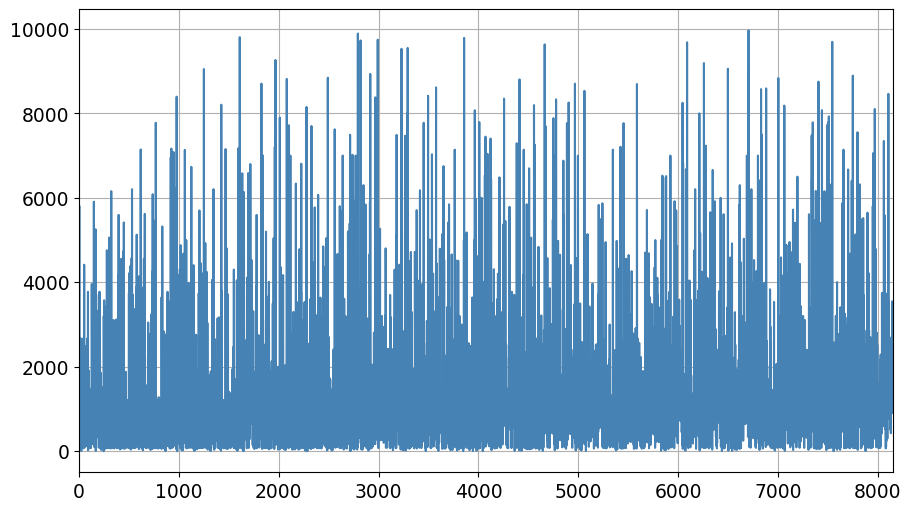

In [79]:
plot_ts(sorted_df.ClaimSeverity_TRG.values[sorted_df.ClaimSeverity_TRG.values < 10000])

In [63]:
calib_predictions_df["0"].ClaimSeverity_PRED.sum()

20765241.754166663

In [69]:
calib_predictions_df["0"].pure_ClaimSeverity_PRED.sum()

10991037.697088534

In [64]:
calib_target_df["0"].ClaimSeverity_TRG.sum()

20765241.754166663

In [68]:
calib_predictions_df["0"].ClaimSeverity_PRED.sort_values()

IDpol
1120377    2498.224465
1159323    2498.224465
2081887    2498.224465
2087868    2498.224465
1197871    2498.224465
              ...     
3189107    2498.224465
4159836    2498.224465
3182210    2498.224465
4159168    2498.224465
1031713    2498.224465
Name: ClaimSeverity_PRED, Length: 8312, dtype: float64

In [65]:
calib_predictions_df["0"].pure_ClaimSeverity_PRED.sort_values()

IDpol
2055918    1174.293208
2100595    1174.293208
2188189    1174.293208
160052     1174.293208
1159231    1174.620075
              ...     
4154625    1755.475468
2177585    1762.886945
1131878    1803.156217
2075585    1812.040549
1088305    1855.335619
Name: pure_ClaimSeverity_PRED, Length: 8312, dtype: float64

In [10]:
predictions_df

{'0':          pure_ClaimFreq_PRED  calibrated_ClaimFreq_PRED  ClaimFreq_PRED
 IDpol                                                                  
 4169479             0.084812                   0.118505        0.118505
 1029561             0.063508                   0.117399        0.117399
 6101794             0.178691                   0.123507        0.123507
 4120268             0.189139                   0.124076        0.124076
 76230               0.495778                   0.142012        0.142012
 ...                      ...                        ...             ...
 2069846             0.143597                   0.121613        0.121613
 2069826             0.137237                   0.121273        0.121273
 2069827             0.234025                   0.126553        0.126553
 2069892             0.166104                   0.122824        0.122824
 2069907             0.121476                   0.120434        0.120434
 
 [67801 rows x 3 columns],
 '1':          pu

In [26]:
mlflow.artifacts.list_artifacts(run_id=mlflow_run_id, artifact_path="results/test")

[<FileInfo: file_size=2611, is_dir=False, path='results/test/pure_test_metrics_by_part.csv'>,
 <FileInfo: file_size=684, is_dir=False, path='results/test/pure_test_metrics_cv_stats.csv'>,
 <FileInfo: file_size=2590, is_dir=False, path='results/test/test_metrics_by_part.csv'>,
 <FileInfo: file_size=632, is_dir=False, path='results/test/test_metrics_cv_stats.csv'>]

In [42]:
metrics_cv_stats = load_metrics_cv_stats_from_mlflow(dataset="test", mlflow_run_id = mlflow_run_id)

In [43]:
metrics_by_part = load_metrics_table_from_mlflow(dataset="test", mlflow_run_id = mlflow_run_id)

In [44]:
metrics_by_part

part               0         1         2         3         4         5  \
metric                                                                   
test_MPD    0.885846  1.052887  1.027052  0.944465  1.111153  0.825786   
test_wMPD   0.505019  0.502245  0.489405  0.494871  0.484315  0.488367   
test_RMSE   1.513411  2.012962  2.210971  1.782154  2.090518  1.157011   
test_wRMSE  0.475220  0.497380  0.490774  0.474673  0.507172  0.460856   
test_R2    -0.000013 -0.000033  0.000057 -0.000039 -0.000118  0.000160   
test_wR2   -0.009950 -0.008303 -0.005438 -0.012563 -0.003927 -0.005484   
test_MBD   -0.013600  0.003708  0.007861 -0.015178  0.021936 -0.005455   
test_wMBD  -0.048384 -0.044381 -0.038422 -0.054090 -0.032194 -0.035958   
test_SC     0.026622  0.022289  0.028210  0.023575  0.019243  0.023648   
test_SRC    0.026622  0.022289  0.028210  0.023575  0.019243  0.023648   
test_GINI   0.086352  0.016149  0.115341  0.074616  0.049831  0.099135   
test_wGINI  0.391130  0.379032  0.393001  0.381377  0.376528  0.384240   

part               6         7         8         9  
metric                                              
test_MPD    0.929565  1.133675  0.961578  1.134429  
test_wMPD   0.500906  0.494655  0.497689  0.491305  
test_RMSE   2.081918  2.446309  1.874213  2.471737  
test_wRMSE  0.478562  0.513426  0.475881  0.522860  
test_R2    -0.000037  0.000024  0.000135 -0.000001  
test_wR2   -0.012740 -0.006914 -0.012645 -0.004112  
test_MBD   -0.018451  0.014418 -0.014462  0.018672  
test_wMBD  -0.053802 -0.040086 -0.053971 -0.035364  
test_SC     0.024641  0.023222  0.027876  0.026632  
test_SRC    0.024641  0.023222  0.027876  0.026632  
test_GINI   0.091366  0.132868  0.136062  0.101308  
test_wGINI  0.385324  0.382347  0.392781  0.389903

In [132]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# # Example dataset
# X = pd.DataFrame({"x1": [0, 1, 2, 3, 4]})
# y = pd.Series([1e6, 1e3, 2e3, 1e7, 1])  # Positive target values (Gamma distributed)
# Example dataset
X = pd.DataFrame({"x1": [1, 2, 3, 4]})
y = pd.Series([1e3, 1e5, 1e6, 1e3])
# X = pd.DataFrame({"x1": [1, 2, 3]})
# y = pd.Series([1e3, 1e5, 1e6])

# Add a constant for the intercept
X = sm.add_constant(X)

# Fit a Gamma GLM with an Inverse link
model = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.InversePower()))
results = model.fit(tol=1e-16, method="newton")

# Print the model summary
print(results.summary())

# Check predictions
predictions = results.predict(X)
print("Predictions:", predictions)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                    4
Model:                            GLM   Df Residuals:                        2
Model Family:                   Gamma   Df Model:                            1
Link Function:           InversePower   Scale:                          3.0733
Method:                        newton   Log-Likelihood:                -58.266
Date:                Sat, 28 Dec 2024   Deviance:                       75.650
Time:                        23:19:41   Pearson chi2:                     6.15
No. Iterations:                     6   Pseudo R-squ. (CS):             -78.46
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.963e-05   9.02e-05      0.994      0.3

/home/krzysiek/Development/claim-modelling/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [127]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# # Example dataset
# X = pd.DataFrame({"x1": [0, 1, 2, 3, 4]})
# y = pd.Series([1e6, 1e3, 2e3, 1e7, 1])  # Positive target values (Gamma distributed)
# Example dataset
X = pd.DataFrame({"x1": [1, 2, 3, 4]})
y = pd.Series([1e3, 1e5, 1e6, 1e3])
# X = pd.DataFrame({"x1": [1, 2, 3]})
# y = pd.Series([1e3, 1e5, 1e6])

# Add a constant for the intercept
X = sm.add_constant(X)

# Fit a Gamma GLM with an Inverse link
model = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.Log()))
results = model.fit()

# Print the model summary
print(results.summary())

# Check predictions
predictions = results.predict(X)
print("Predictions:", predictions)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                    4
Model:                            GLM   Df Residuals:                        2
Model Family:                   Gamma   Df Model:                            1
Link Function:                    Log   Scale:                          1.7795
Method:                          IRLS   Log-Likelihood:                -49.530
Date:                Sat, 28 Dec 2024   Deviance:                       17.810
Time:                        23:15:04   Pearson chi2:                     3.56
No. Iterations:                    70   Pseudo R-squ. (CS):             0.4388
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7961      1.634      4.160      0.0

In [147]:
z = [-2, -1, 0.5, 0., 0.5, 1, 2]
power = 1.2
np.power(z, 1. / power) 

/tmp/ipykernel_9496/4249915722.py:3: RuntimeWarning: invalid value encountered in power
  np.power(z, 1. / power)


array([       nan,        nan, 0.56123102, 0.        , 0.56123102,
       1.        , 1.78179744])

## Ordering by prediction and hash

In [10]:
import hashlib


def stable_str_hash(x: Any, seed: str = "") -> str:
    """
    Deterministic and unique string hash for an input.

    Args:
        x (int): The integer to hash.
        seed (str): Optional string to introduce variability across runs.

    Returns:
        str: Hexadecimal SHA256 hash of the input.
    """
    s = f"{seed}-{x}"
    return hashlib.sha256(s.encode()).hexdigest()


def ordered_by_pred_and_hashed_index(
        y_true: Union[pd.Series, np.ndarray],
        y_pred: Union[pd.Series, np.ndarray],
        sample_weight: Union[pd.Series, np.ndarray] = None
) -> Tuple[pd.Series, pd.Series, pd.Series]:
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    if sample_weight is None:
        sample_weight = pd.Series(np.ones_like(y_true), index=y_true.index)
    else:
        sample_weight = pd.Series(sample_weight)

    # Sort inputs stably by y_pred, then by hash of index
    secondary_key = y_pred.index.to_series().apply(lambda x: stable_str_hash(x)).values
    primary_key = y_pred.values
    sorted_idx = np.lexsort((secondary_key, primary_key))

    y_true = y_true.iloc[sorted_idx].reset_index(drop=True)
    y_pred = y_pred.iloc[sorted_idx].reset_index(drop=True)
    sample_weight = sample_weight.iloc[sorted_idx].reset_index(drop=True)

    return y_true, y_pred, sample_weight

In [393]:
df.index.to_series()

IDpol
2141337    2141337
3150210    3150210
3059946    3059946
2202813    2202813
4138268    4138268
            ...   
59621        59621
1167638    1167638
62913        62913
4158800    4158800
175914      175914
Name: IDpol, Length: 4987, dtype: int64

In [394]:
df2.index.to_series()

IDpol
5091954    5091954
3122146    3122146
178693      178693
2004978    2004978
1178614    1178614
            ...   
2264323    2264323
1116710    1116710
1155051    1155051
2147703    2147703
3142847    3142847
Name: IDpol, Length: 4987, dtype: int64

In [395]:
pd.Series(np.ones_like(df.index))

0       1
1       1
2       1
3       1
4       1
       ..
4982    1
4983    1
4984    1
4985    1
4986    1
Length: 4987, dtype: int64

In [404]:
df2 = df.copy()
df2["hash"] = df.ClaimSeverity_PRED.index.to_series().apply(lambda x: stable_str_hash(x)).values
df2.sort_values("hash", inplace=True)

import wcorr

wcorr.WeightedCorr(x=pd.Series(df.index.values), y=pd.Series(df2.index.values), w=pd.Series(np.ones_like(df.index)))(method="spearman")

0.009524273947897005

## Concentration Index

In [180]:
class NormalizedConcentrationIndex(Metric):
    def __init__(self, config: Config, **kwargs):
        super().__init__(config, sklearn_like_metric=self._weighted_normalized_concentration_index, **kwargs)

    @staticmethod
    def _weighted_concentration_index(y_true: pd.Series, y_pred: pd.Series, sample_weight: pd.Series = None):
        """
        Compute the weighted Concentration Index.
    
        Args:
            y_true (pd.Series): Series of true values.
            y_pred (pd.Series): Series of predicted values.
            sample_weight (pd.Series): Series of sample weights. If None, all weights are set to 1.
    
        Returns:
            float: Weighted Concentration Index.
        """
        assert len(y_true) == len(y_pred), "y_true and y_pred must have the same length"
    
        y_true, y_pred, sample_weight = ordered_by_pred_and_hashed_index(y_true, y_pred, sample_weight)
    
        # Normalize weights and compute weighted mean of y
        w = sample_weight.values
        W = np.sum(w)
        y = y_true.values
        y_bar = np.average(y, weights=w)
        
        # Compute cumulative weights to obtain fractional ranks
        cum_weights = np.cumsum(w)
        fractional_ranks = (cum_weights - 0.5 * w) / W  # centroid of bin i
        
        # Formula: CI = 2 * sum((w_i / W) * R_i * y_i / ȳ) - 1
        ci = 2 * np.sum((w / W) * fractional_ranks * y / y_bar) - 1
    
        return ci

    @staticmethod
    def _weighted_normalized_concentration_index(y_true: pd.Series, y_pred: pd.Series, sample_weight: pd.Series = None):
        """
        Compute the normalized weighted Concentration Index.

        Args:
            y_true (pd.Series): Series of true values.
            y_pred (pd.Series): Series of predicted values.
            sample_weight (pd.Series): Series of sample weights. If None, all weights are set to 1.

        Returns:
            float: Normalized weighted Concentration Index.
        """
        concentration_index_pred = NormalizedConcentrationIndex._weighted_concentration_index(y_true, y_pred, sample_weight)
        concentration_index_true = NormalizedConcentrationIndex._weighted_concentration_index(y_true, y_true, sample_weight)

        # Avoid division by zero
        if np.isclose(concentration_index_true, 0, atol=1e-5):
            return 0.0

        return concentration_index_pred / concentration_index_true

    def _get_name(self) -> str:
        return "Normalized Concentration Index"

    def _get_short_name(self) -> str:
        return "NCI"

    def get_enum(self) -> MetricType:
        if self.exposure_weighted:
            return MetricEnum.EXP_WEIGHTED_CONCENTRATION_INDEX
        if self.claim_nb_weighted:
            return MetricEnum.CLNB_WEIGHTED_CONCENTRATION_INDEX
        return MetricEnum.CONCENTRATION_INDEX

    def is_larger_better(self) -> bool:
        return True

NameError: name 'MetricType' is not defined

In [179]:
def weighted_concentration_index(y_true: pd.Series, y_pred: pd.Series, sample_weight: pd.Series = None):
    """
    Compute the weighted Concentration Index.

    Args:
        y_true (pd.Series): Series of true values.
        y_pred (pd.Series): Series of predicted values.
        sample_weight (pd.Series): Series of sample weights. If None, all weights are set to 1.

    Returns:
        float: Weighted Concentration Index.
    """
    assert len(y_true) == len(y_pred), "y_true and y_pred must have the same length"

    y_true, y_pred, sample_weight = ordered_by_pred_and_hashed_index(y_true, y_pred, sample_weight)

    # Normalize weights and compute weighted mean of y
    w = sample_weight.values
    W = np.sum(w)
    y = y_true.values
    y_bar = np.average(y, weights=w)
    
    # Compute cumulative weights to obtain fractional ranks
    cum_weights = np.cumsum(w)
    fractional_ranks = (cum_weights - 0.5 * w) / W  # centroid of bin i
    
    # Formula: CI = 2 * sum((w_i / W) * R_i * y_i / ȳ) - 1
    ci = 2 * np.sum((w / W) * fractional_ranks * y / y_bar) - 1

    return ci

In [171]:
df.Exposure

IDpol
2124033    0.002740
91820      0.005464
3002643    0.005479
2162875    0.005479
2206399    0.005479
             ...   
2069939    1.000000
2069879    1.000000
2069891    0.270000
2069895    0.410000
2069906    0.810000
Name: Exposure, Length: 135601, dtype: float64

In [175]:
weighted_concentration_index(df.ClaimFreq_TRG, df.ClaimFreq_PRED, df.Exposure)

0.1442103634875045

In [176]:
weighted_concentration_index(df.ClaimFreq_TRG, df.ClaimFreq_TRG, df.Exposure)

0.9650334769514362

In [177]:
weighted_concentration_index(df.ClaimFreq_TRG, df.ClaimFreq_PRED)

0.10620479660269821

In [178]:
weighted_concentration_index(df.ClaimFreq_TRG, df.ClaimFreq_TRG)

0.9842610272205756

In [364]:
weighted_concentration_index(df.ClaimSeverity_TRG, df.ClaimSeverity_PRED, df.ClaimNb_TRG)

0.08907524499381769

In [365]:
weighted_concentration_index(df.ClaimSeverity_TRG, df.ClaimSeverity_TRG, df.ClaimNb_TRG)

0.31434332528401043

In [366]:
weighted_concentration_index(df.ClaimSeverity_TRG, df.ClaimSeverity_PRED, df.ClaimNb_TRG)

0.08907524499381769

In [367]:
weighted_concentration_index(df.ClaimSeverity_TRG, df.ClaimSeverity_TRG, df.ClaimNb_TRG)

0.31434332528401043

In [368]:
weighted_concentration_index(df.ClaimSeverity_TRG, df.ClaimSeverity_PRED, df.ClaimNb_TRG)

0.08907524499381769

In [369]:
weighted_concentration_index(df.ClaimSeverity_TRG, df.ClaimSeverity_TRG, df.ClaimNb_TRG)

0.31434332528401043

## Concentration curve

In [155]:
def determine_y_axis_label(show_cc: bool, show_oracle: bool, show_lorentz: bool) -> str:
    """
    Determine the Y-axis label based on which curves are shown.
    """
    if (not show_cc and not show_oracle) and show_lorentz:
        return "Cumulative Proportion of Predicted Values"
    elif (show_cc or show_oracle) and not show_lorentz:
        return "Cumulative Proportion of True Values"
    elif (show_cc or show_oracle) and show_lorentz:
        return "Cumulative Proportion of True / Predicted Values"
    else:
        return "Cumulative Proportion"


def update_plot_concentration_curve_axis_label(ax, show_cc, show_oracle, show_lorentz):
    """
    Updates the Y-axis label for the concentration curve plot.

    Args:
        ax: The matplotlib axis object to update.
        show_cc (bool): Indicates if the concentration curve is displayed.
        show_oracle (bool): Indicates if the oracle curve is displayed.
        show_lorentz (bool): Indicates if the Lorenz curve is displayed.
    """
    label = determine_y_axis_label(show_cc, show_oracle, show_lorentz)
    ax.set_ylabel(label)


def update_plot_mean_concentration_curve_axis_label(ax, show_cc, show_oracle, show_lorentz):
    """
    Updates the Y-axis label for the mean concentration curve plot.

    Args:
        ax: The matplotlib axis object to update.
        show_cc (bool): Indicates if the concentration curve is displayed.
        show_oracle (bool): Indicates if the oracle curve is displayed.
        show_lorentz (bool): Indicates if the Lorenz curve is displayed.
    """
    label = determine_y_axis_label(show_cc, show_oracle, show_lorentz)
    ax.set_ylabel(label)

In [156]:
def calculate_concentration_curve(y_true: pd.Series, y_pred: pd.Series, sample_weight: pd.Series = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculate the points for the Lorentz curve based on true and predicted values, considering observation weights.

    Args:
        y_true (np.ndarray or pd.Series): True values.
        y_pred (np.ndarray or pd.Series): Predicted values.
        sample_weight (np.ndarray or pd.Series, optional): Weights for observations. Defaults to equal weights.

    Returns:
        tuple: (x_points, y_points) for the weighted Lorentz curve.
    """
    y_true, y_pred, sample_weight = ordered_by_pred_and_hashed_index(y_true, y_pred, sample_weight)

    # Weighted cumulative sum of true values
    weighted_true = y_true * sample_weight
    cumulative_weighted_true = np.cumsum(weighted_true)

    # Total weighted true value
    total_weighted_true = np.sum(weighted_true)

    # Weighted cumulative count of observations
    cumulative_weighted_count = np.cumsum(sample_weight)
    total_weighted_count = np.sum(sample_weight)

    # Calculate Lorentz curve points
    x_points = np.insert(cumulative_weighted_count / total_weighted_count, 0, 0)  # Proportion of total weighted observations
    y_points = np.insert(cumulative_weighted_true / total_weighted_true, 0, 0)  # Proportion of total weighted true values

    return x_points, y_points

In [157]:
def plot_concentration_curve(
    y_true: pd.Series,
    y_pred: pd.Series,
    sample_weight: Optional[pd.Series] = None,
    title: str = "Concentration Curve",
    marker: Optional[str] = None,
    show_cc: bool = True,
    show_oracle: bool = False,
    fill_between_cc_and_oracle: bool = False,
    fill_between_equity_and_cc: bool = True,
    show_std_band: bool = False,  # Placeholder for API compatibility
    show_all_curves: bool = False,  # Placeholder for API compatibility
    show_lorenz: bool = False,
    fill_between_cc_and_lorenz: bool = False,
    fill_under_lorenz: bool = False,
    n_points: int = 100
) -> plt.Figure:
    """
    Generates a concentration curve plot based on true and predicted values.

    Args:
        y_true (pd.Series): True target values.
        y_pred (pd.Series): Predicted target values.
        sample_weight (Optional[pd.Series]): Weights for observations (optional).
        title (str): Title of the plot.
        marker (Optional[str]): Marker style for the plot points.
        show_cc (bool): Whether to display the concentration curve.
        show_oracle (bool): Whether to display the oracle curve (ideal curve).
        fill_between_cc_and_oracle (bool): Whether to fill the area between the concentration curve and the oracle curve.
        fill_between_equity_and_cc (bool): Whether to fill the area between the line of equality and the concentration curve.
        show_std_band (bool): Placeholder for API compatibility (not used in this function).
        show_all_curves (bool): Placeholder for API compatibility (not used in this function).
        show_lorenz (bool): Whether to display the Lorenz curve.
        fill_between_cc_and_lorenz (bool): Whether to fill the area between the concentration curve and the Lorenz curve.
        fill_under_lorenz (bool): Whether to fill the area under the Lorenz curve.
        n_points (int): Number of interpolation points for the curves.

    Returns:
        plt.Figure: A matplotlib figure object containing the concentration curve plot.
    """
    x_interp = np.linspace(0, 1, n_points)
    fig, ax = plt.subplots(figsize=(8, 6))

    if show_cc:
        x_cc, y_cc = calculate_concentration_curve(y_true, y_pred, sample_weight)
        y_cc_interp = np.interp(x_interp, x_cc, y_cc)
        ax.plot(x_interp, y_cc_interp, label="Concentration Curve", color="blue", marker=marker)
        if fill_between_equity_and_cc:
            ax.fill_between(x_interp, y_cc_interp, y2=x_interp, color="blue", alpha=0.05)
    else:
        y_cc_interp = None

    if show_oracle:
        x_oracle, y_oracle = calculate_concentration_curve(y_true, y_true, sample_weight)
        y_oracle_interp = np.interp(x_interp, x_oracle, y_oracle)
        ax.plot(x_interp, y_oracle_interp, label="Oracle Curve", linestyle="--", color="black")
        if fill_between_cc_and_oracle and y_cc_interp is not None:
            ax.fill_between(x_interp, y_oracle_interp, y_cc_interp, color="gray", alpha=0.05)

    if show_lorenz:
        x_lorenz, y_lorenz = calculate_concentration_curve(y_pred, y_pred, sample_weight)
        y_lorenz_interp = np.interp(x_interp, x_lorenz, y_lorenz)
        ax.plot(x_interp, y_lorenz_interp, label="Lorenz Curve", linestyle="-.", color="green")
        if fill_between_cc_and_lorenz and y_cc_interp is not None:
            ax.fill_between(x_interp, y_cc_interp, y_lorenz_interp, color="green", alpha=0.05)
        if fill_under_lorenz:
            ax.fill_between(x_interp, 0, y_lorenz_interp, color="green", alpha=0.03)

    ax.plot([0, 1], [0, 1], label="Line of Equality", linestyle="dotted", color="black")
    ax.set_xlabel("Cumulative Proportion of Observations (Ordered by Predicted Values)")
    update_plot_concentration_curve_axis_label(ax, show_cc, show_oracle, show_lorenz)
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    plt.close(fig)
    return fig

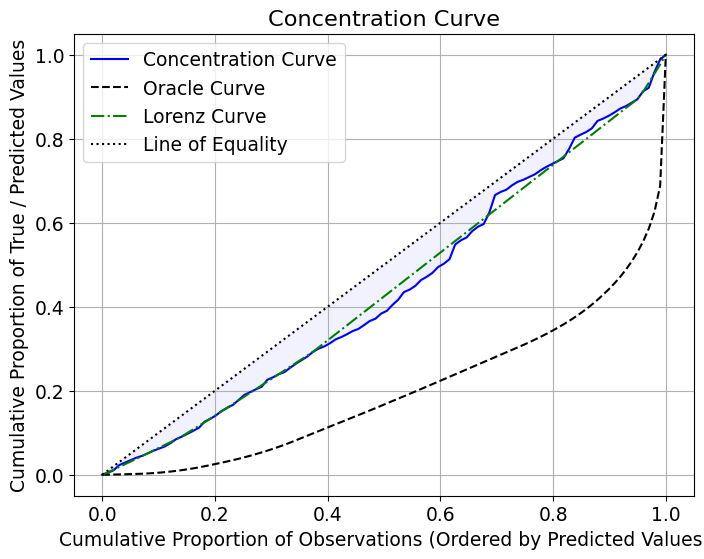

In [152]:
plot_concentration_curve(y_true=df.ClaimSeverity_TRG, y_pred = df.ClaimSeverity_PRED, sample_weight=df.ClaimNb_TRG,
    show_cc = True,
    show_oracle= True,
    fill_between_cc_and_oracle=False,
    fill_between_equity_and_cc = True,
    show_std_band=False,  # Placeholder for API compatibility
    show_all_curves = False,  # Placeholder for API compatibility
    show_lorenz = True,
    fill_between_cc_and_lorenz = False,
    fill_under_lorenz = False,
    n_points = 100)

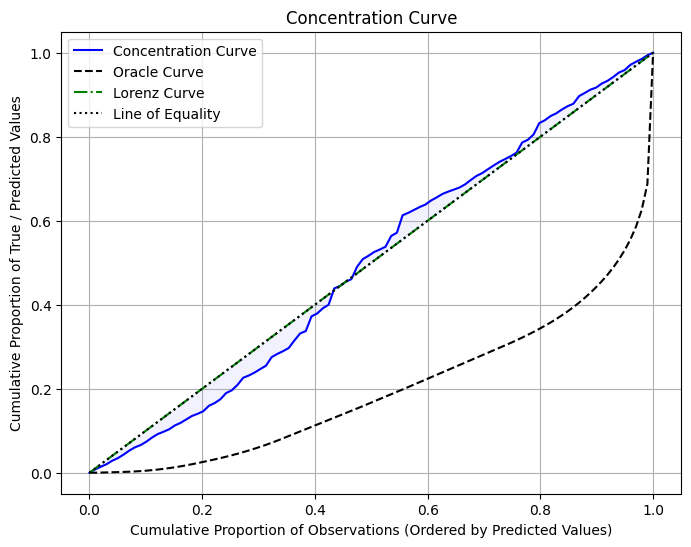

In [451]:
plot_concentration_curve(y_true=df.ClaimSeverity_TRG, y_pred = pd.Series(np.ones_like(df.ClaimSeverity_TRG) * df.ClaimSeverity_TRG.mean(), index=df.index), sample_weight=df.ClaimNb_TRG,
    show_cc = True,
    show_oracle= True,
    fill_between_cc_and_oracle=False,
    fill_between_equity_and_cc = True,
    show_std_band=False,  # Placeholder for API compatibility
    show_all_curves = False,  # Placeholder for API compatibility
    show_lorenz = True,
    fill_between_cc_and_lorenz = False,
    fill_under_lorenz = False,
    n_points= 100)

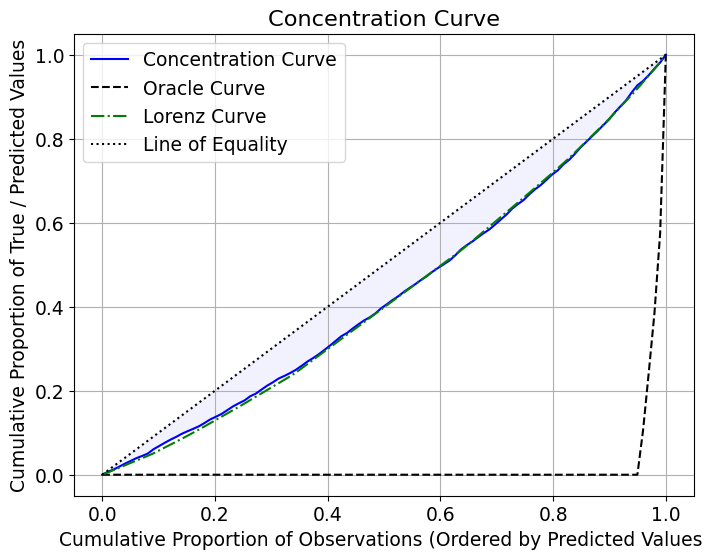

In [158]:
plot_concentration_curve(y_true=df.ClaimFreq_TRG, y_pred = df.ClaimFreq_PRED, sample_weight=df.Exposure,
    show_cc = True,
    show_oracle= True,
    fill_between_cc_and_oracle=False,
    fill_between_equity_and_cc = True,
    show_std_band=False,  # Placeholder for API compatibility
    show_all_curves = False,  # Placeholder for API compatibility
    show_lorenz = True,
    fill_between_cc_and_lorenz = False,
    fill_under_lorenz = False,
    n_points = 100)

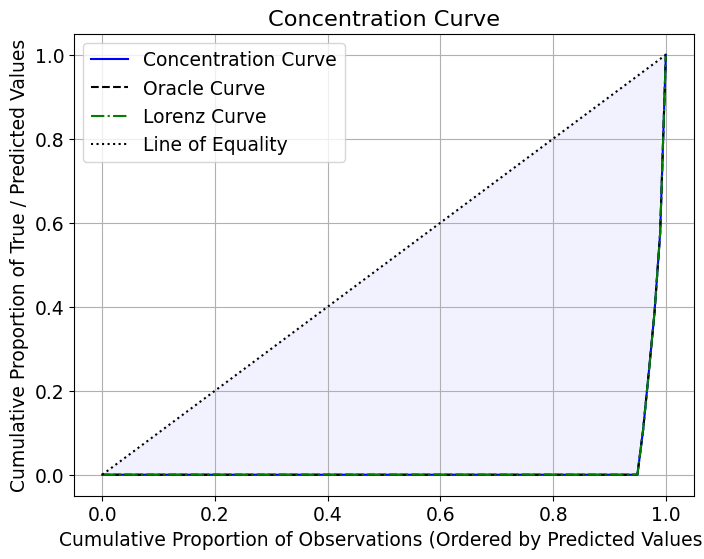

In [159]:
plot_concentration_curve(y_true=df.ClaimFreq_TRG, y_pred = df.ClaimFreq_TRG, sample_weight=df.Exposure,
    show_cc = True,
    show_oracle= True,
    fill_between_cc_and_oracle=False,
    fill_between_equity_and_cc = True,
    show_std_band=False,  # Placeholder for API compatibility
    show_all_curves = False,  # Placeholder for API compatibility
    show_lorenz = True,
    fill_between_cc_and_lorenz = False,
    fill_under_lorenz = False,
    n_points = 100)

## Mean Concentration Curve

In [62]:
def plot_mean_concentration_curve(
    y_true_dict: Dict[str, pd.Series],
    y_pred_dict: Dict[str, pd.Series],
    sample_weight_dict: Dict[str, pd.Series] = None,
    title: str = "Mean Concentration Curve across Partitions",
    marker: str = None,
    show_cc: bool = True,
    show_oracle: bool = False,
    fill_between_cc_and_oracle: bool = False,
    fill_between_equity_and_cc: bool = True,
    show_std_band: bool = True,
    show_all_curves: bool = False,
    show_lorenz: bool = False,
    fill_between_cc_and_lorenz: bool = False,
    fill_under_lorenz: bool = False,
    n_points: int = 100
) -> plt.Figure:
    """
    Generates a plot of the mean concentration curve across multiple partitions.

    Args:
        y_true_dict (Dict[str, pd.Series]): Dictionary of true target values for each partition.
        y_pred_dict (Dict[str, pd.Series]): Dictionary of predicted target values for each partition.
        sample_weight_dict (Dict[str, pd.Series], optional): Dictionary of sample weights for each partition. Defaults to None.
        title (str): Title of the plot.
        marker (str, optional): Marker style for the plot points. Defaults to None.
        show_cc (bool): Whether to display the concentration curve. Defaults to True.
        show_oracle (bool): Whether to display the oracle curve (ideal curve). Defaults to False.
        fill_between_cc_and_oracle (bool): Whether to fill the area between the concentration curve and the oracle curve. Defaults to False.
        fill_between_equity_and_cc (bool): Whether to fill the area between the line of equality and the concentration curve. Defaults to True.
        show_std_band (bool): Whether to display the standard deviation band around the mean curve. Defaults to True.
        show_all_curves (bool): Whether to display all individual curves for each partition. Defaults to False.
        show_lorenz (bool): Whether to display the Lorenz curve. Defaults to False.
        fill_between_cc_and_lorenz (bool): Whether to fill the area between the concentration curve and the Lorenz curve. Defaults to False.
        fill_under_lorenz (bool): Whether to fill the area under the Lorenz curve. Defaults to False.
        n_points (int): Number of interpolation points for the curves. Defaults to 100.

    Returns:
        plt.Figure: A matplotlib figure object containing the mean concentration curve plot.
    """
    x_interp = np.linspace(0, 1, n_points)
    y_interp_all, oracle_interp_all, lorenz_interp_all = [], [], []

    for part in y_true_dict:
        weights = sample_weight_dict.get(part) if sample_weight_dict else None

        if show_cc:
            x, y = calculate_concentration_curve(y_true_dict[part], y_pred_dict[part], weights)
            y_interp = np.interp(x_interp, x, y)
            y_interp_all.append(y_interp)
            if show_all_curves:
                plt.plot(x, y, label=f"CC for {part}", alpha=0.3)

        if show_oracle:
            xo, yo = calculate_concentration_curve(y_true_dict[part], y_true_dict[part], weights)
            oracle_interp = np.interp(x_interp, xo, yo)
            oracle_interp_all.append(oracle_interp)

        if show_lorenz:
            xl, yl = calculate_concentration_curve(y_pred_dict[part], y_pred_dict[part], weights)
            lorenz_interp = np.interp(x_interp, xl, yl)
            lorenz_interp_all.append(lorenz_interp)

    fig, ax = plt.subplots(figsize=(8, 6))

    if show_cc and y_interp_all:
        y_interp_all = np.array(y_interp_all)
        mean_y = np.mean(y_interp_all, axis=0)
        std_y = np.std(y_interp_all, axis=0)
        ax.plot(x_interp, mean_y, label="Mean Concentration Curve", color="blue", marker=marker)
        if show_std_band:
            ax.fill_between(x_interp, mean_y - std_y, mean_y + std_y, color="blue", alpha=0.1, label="±1 Std. Dev.")
        if fill_between_equity_and_cc:
            ax.fill_between(x_interp, mean_y, y2=x_interp, color="blue", alpha=0.05)

    if show_oracle and oracle_interp_all:
        oracle_interp_all = np.array(oracle_interp_all)
        mean_oracle_y = np.mean(oracle_interp_all, axis=0)
        std_oracle_y = np.std(oracle_interp_all, axis=0)
        ax.plot(x_interp, mean_oracle_y, label="Mean Oracle Curve", color="black", linestyle="--")
        if show_std_band:
            ax.fill_between(x_interp, mean_oracle_y - std_oracle_y, mean_oracle_y + std_oracle_y,
                            color="gray", alpha=0.1, label="Oracle ±1 Std. Dev.")
        if fill_between_cc_and_oracle and show_cc:
            ax.fill_between(x_interp, mean_oracle_y, mean_y, color="gray", alpha=0.05)

    if show_lorenz and lorenz_interp_all:
        lorenz_interp_all = np.array(lorenz_interp_all)
        mean_lorenz_y = np.mean(lorenz_interp_all, axis=0)
        std_lorenz_y = np.std(lorenz_interp_all, axis=0)
        ax.plot(x_interp, mean_lorenz_y, label="Mean Lorenz Curve", linestyle="-.", color="green")
        if show_std_band:
            ax.fill_between(x_interp, mean_lorenz_y - std_lorenz_y, mean_lorenz_y + std_lorenz_y,
                            color="green", alpha=0.1, label="Lorenz ±1 Std. Dev.")
        if fill_between_cc_and_lorenz and show_cc:
            ax.fill_between(x_interp, mean_y, mean_lorenz_y, color="green", alpha=0.05)
        if fill_under_lorenz:
            ax.fill_between(x_interp, 0, mean_lorenz_y, color="green", alpha=0.03)

    ax.plot([0, 1], [0, 1], label="Line of Equality", linestyle="dotted", color="black")
    ax.set_xlabel("Cumulative Proportion of Observations (Ordered by Predicted Values)")
    update_plot_mean_concentration_curve_axis_label(ax, show_cc, show_oracle, show_lorenz)
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    plt.close(fig)
    return fig

## Area between CC and LC

In [442]:
def weighted_area_between_cc_and_lc(y_true: pd.Series, y_pred: pd.Series, sample_weight: pd.Series = None):
    """
    Compute the weighted Concentration Index.

    Args:
        y_true (pd.Series): Series of true values.
        y_pred (pd.Series): Series of predicted values.
        sample_weight (pd.Series): Series of sample weights. If None, all weights are set to 1.

    Returns:
        float: Weighted Concentration Index.
    """
    assert len(y_true) == len(y_pred), "y_true and y_pred must have the same length"

    x_cc, y_cc = calculate_concentration_curve(y_true, y_pred, sample_weight)
    x_lc, y_lc = calculate_concentration_curve(y_pred, y_pred, sample_weight)

    aucc = np.trapz(y=y_cc, x=x_cc)
    aucl = np.trapz(y=y_lc, x=x_lc)

    return aucc - aucl

## Percentile Statistics

In [65]:
def prediction_group_summary_strict_bins(
    y_true: Union[pd.Series, np.ndarray],
    y_pred: Union[pd.Series, np.ndarray],
    sample_weight: Union[pd.Series, np.ndarray],
    n_bins: int,
    groups: List[int] = None,
    round_precision: int = None,
    as_int: bool = False
) -> pd.DataFrame:
    y_true, y_pred, sample_weight = ordered_by_pred_and_hashed_index(y_true, y_pred, sample_weight)
    df = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
        "weight": sample_weight
    })

    bin_label_name = "group"
    group_numbers = np.zeros(len(df), dtype=int)
    for i, idx in enumerate(df.index):
        group_numbers[idx] = (i * n_bins) // len(df) + 1  # 1-based group index

    df[bin_label_name] = group_numbers

    # Filter by specified groups
    if groups is not None:
        df = df[df[bin_label_name].isin(groups)]

    # Group and compute statistics
    def weighted_mean(x, w):
        return np.average(x, weights=w)

    def weighted_std(x, w):
        average = weighted_mean(x, w)
        return np.sqrt(np.average((x - average) ** 2, weights=w))

    def weighted_quantile(values, quantiles, sample_weight):
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]
        weighted_cdf = np.cumsum(sample_weight) - 0.5 * sample_weight
        weighted_cdf /= np.sum(sample_weight)
        return np.interp(quantiles, weighted_cdf, values)

    def round_arr(arr):
        arr = np.array(arr).astype(float)
        if round_precision is not None:
            arr = np.round(arr, round_precision)
        if as_int:
            arr = arr.astype(int)
        return arr

    summary_rows = []
    for group, group_df in df.groupby(bin_label_name):
        w = group_df["weight"].values
        yt = group_df["y_true"].values
        yp = group_df["y_pred"].values

        stats = {
            "group": group,
            "n_obs": len(group_df),
            "mean_pred": round_arr(weighted_mean(yp, w)),
            "mean_target": round_arr(weighted_mean(yt, w)),
            "std_pred": round_arr(weighted_std(yp, w)),
            "std_target": round_arr(weighted_std(yt, w)),
        }

        q_vals = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
        quantiles = weighted_quantile(yt, quantiles=q_vals, sample_weight=w)
        for q, val in zip(q_vals, quantiles):
            stats[f"q_{int(q * 100):02d}"] = round_arr(val)

        summary_rows.append(stats)

    summary_df = pd.DataFrame(summary_rows)
    summary_df.sort_values("group", inplace=True)
    summary_df.reset_index(drop=True, inplace=True)

    return summary_df


In [66]:
np.round([0.1, 3], 1)

array([0.1, 3. ])

In [67]:
summary_df = prediction_group_summary_strict_bins(y_true=df.ClaimSeverity_TRG, y_pred = df.ClaimSeverity_PRED, sample_weight=df.ClaimNb_TRG, round_precision=0, as_int=True, n_bins=20)
summary_df

group  n_obs  mean_pred  mean_target  std_pred  std_target  q_01  q_10  \
0       1    250       1296         1413       135        4146    35    96   
1       2    249       1352         1166        21        1390    42   156   
2       3    250       1430         1421       129        2587    18   172   
3       4    249       1746         1851        24        3326    22    80   
4       5    249       1814         1840         5        2739    17   353   
5       6    250       1823         1911         0        5994    39   393   
6       7    249       1823         1577         0        2892    38   139   
7       8    249       1994         1735       177        4629    56   218   
8       9    250       2178         1433         0        2491    48   206   
9      10    249       2178         1773         0        3856    62   270   
10     11    249       2178         2415         0        6973    34   351   
11     12    250       2178         2216         0        4824    65   252   
12     13    249       2178         2855         0       17609    37   241   
13     14    249       2178         4227         0       19671    75   239   
14     15    250       2178         1497         0        1693    23   200   
15     16    249       2178         1579         0        2459    60   306   
16     17    249       2178         2884         0       16689    41   372   
17     18    250       2178         1859         0        7167    72   283   
18     19    249       2178         1637         0        2714    49   166   
19     20    249       4340         4340       842       20868    70   369   

    q_25  q_50  q_75  q_90    q_99  
0    589  1128  1204  2033    7502  
1    527  1128  1204  1633    7717  
2    748  1128  1204  2049    7750  
3    659  1172  1319  2943   21113  
4    908  1204  1616  3266   16464  
5    901  1172  1287  2704   10858  
6    613  1128  1385  2746   11823  
7    638  1172  1204  2172   30538  
8    692  1128  1204  2316    9753  
9    635  1172  1404  2860   13248  
10   754  1172  1320  3822   47654  
11   793  1192  1500  4088   20308  
12   712  1172  1320  3052   25446  
13   728  1172  1210  2565  129167  
14   672  1172  1255  3082    8543  
15   860  1143  1237  2739   11856  
16   823  1172  1324  2859   10685  
17   807  1172  1226  2713    8965  
18   602  1172  1204  2827   13419  
19  1120  1204  1841  4511   88651

In [68]:
summary_df = prediction_group_summary_strict_bins(y_true=df.ClaimSeverity_TRG, y_pred = df.pure_ClaimSeverity_PRED, sample_weight=df.ClaimNb_TRG, round_precision=0, as_int=True, n_bins=20)
summary_df

group  n_obs  mean_pred  mean_target  std_pred  std_target  q_01  q_10  \
0       1    250       1306         1402        81        4134    35   101   
1       2    249       1453         1300        28        2523    40   172   
2       3    250       1531         1542        19        2658    10   194   
3       4    249       1589         1687        16        2867    22   115   
4       5    249       1645         1926        15        3582    14   259   
5       6    250       1693         2133        14        6840    39   240   
6       7    249       1740         1633        14        2738    55   179   
7       8    249       1783         2813        12       17881    32   132   
8       9    250       1825         1759        13        5007    59   190   
9      10    249       1869         3218        12       14269    31   274   
10     11    249       1913         1791        13        3159    21   308   
11     12    250       1958         1853        14        4619    30   297   
12     13    249       2005         3267        15       19094    68   321   
13     14    249       2065         2201        19       11188    70   255   
14     15    250       2133         1450        20        1770    72   245   
15     16    249       2213         1583        26        2002    49   336   
16     17    249       2312         1852        36        4793    58   201   
17     18    250       2445         2220        44        5555    75   260   
18     19    249       2677         1600       110        2136    23   420   
19     20    249       3665         4340       715       20868    70   369   

    q_25  q_50  q_75  q_90   q_99  
0    572  1128  1204  2011   7597  
1    612  1128  1204  1814   9893  
2    729  1128  1204  2180  16869  
3    626  1172  1273  2591  16556  
4    866  1172  1400  3048  21745  
5    840  1172  1494  2718  39343  
6    701  1172  1315  3238  10849  
7    653  1172  1314  2180   9436  
8    602  1172  1204  2763  16367  
9    707  1172  1204  3204  76372  
10   686  1172  1320  2845  19467  
11   717  1172  1452  2674  25291  
12   657  1128  1230  3249  65674  
13   624  1172  1320  2701  15693  
14   638  1172  1204  2485   9887  
15   703  1172  1320  3017  12675  
16   676  1172  1226  3185  10739  
17  1004  1176  1323  3661  45071  
18   919  1172  1413  2889   8796  
19  1120  1204  1841  4511  88651

## CV Mean Percentile Statistics

In [60]:
def create_average_prediction_group_summary(
    # config: Config,
    summary_df: Dict[str, pd.DataFrame],
    # dataset: str,
    # n_bins: int,
    # prefix: str = None
) -> None:
    """
    Averages the prediction group summary statistics across partitions and logs the result to MLflow.

    Args:
        config (Config): Configuration object containing settings and parameters.
        stats_df (pd.DataFrame): DataFrame containing the prediction group summary statistics.
        dataset (str): Name of the dataset (e.g., "train" or "test").
        n_bins (int): Number of bins used in the summary.
        prefix (str, optional): Prefix for the dataset ('pure' or None). Defaults to None.
    """
    # dataset = f"{prefix}_{dataset}" if prefix is not None else dataset
    # logger.info(f"Averaging prediction group summary for dataset: {dataset} with {n_bins} bins over partitions...")
    if isinstance(summary_df, Dict):
        summary_df = summary_df.values()
    for df in summary_df:
        df["bias_deviation"] = df["mean_target"] - df["mean_pred"]
        df["mean_overpricing"] = np.max([df["mean_target"], df["mean_pred"]], axis=0) - df["mean_target"]
        df["mean_underpricing"] = df["mean_target"] - np.min([df["mean_target"], df["mean_pred"]], axis=0)
    avg_stats_df = pd.concat(summary_df).groupby(level=0).mean()
    avg_stats_df["std_of_mean_pred"] = pd.concat(summary_df).mean_pred.groupby(level=0).std()
    avg_stats_df["std_of_mean_target"] = pd.concat(summary_df).mean_target.groupby(level=0).std()
    avg_stats_df["std_of_bias_deviation"] = pd.concat(summary_df).bias_deviation.groupby(level=0).std()
    avg_stats_df["std_of_mean_overpricing"] = pd.concat(summary_df).mean_overpricing.groupby(level=0).std()
    avg_stats_df["std_of_mean_underpricing"] = pd.concat(summary_df).mean_underpricing.groupby(level=0).std()
    avg_stats_df["rel_bias_deviation"] = df["bias_deviation"] / df["mean_target"]
    avg_stats_df["rel_mean_overpricing"] = df["mean_overpricing"] / df["mean_target"]
    avg_stats_df["rel_mean_underpricing"] = df["mean_underpricing"] / df["mean_target"]

    # Save and log the averaged summary DataFrame as a CSV file to MLflow
    # with tempfile.TemporaryDirectory() as temp_dir:
    #     filename = get_file_name(FILE_NAME_AVERAGE_PRED_GROUPS_SUMMARY, dataset, n_bins)
    #     artifact_path = ARTIFACT_PATH_PRED_GROUPS_SUMMARY
    #     csv_path = os.path.join(temp_dir, filename)
    #     avg_stats_df.to_csv(csv_path, index=False)
    #     mlflow.log_artifact(csv_path, artifact_path=artifact_path)
    #     logger.info(f"Averaged prediction group summary for dataset: {dataset} over partitions logged to MLflow as {os.path.join(artifact_path, filename)}.")
    return avg_stats_df


summary_dfs = [create_prediction_group_summary_strict_bins(y_true=df_trg.ClaimSeverity_TRG, y_pred = df_pred.ClaimSeverity_PRED, sample_weight=df_trg.ClaimNb_TRG, round_precision=0, as_int=True, n_bins=10)
               for df_pred, df_trg in zip(calib_predictions_df.values(), calib_target_df.values())]
create_average_prediction_group_summary(summary_dfs)

TypeError: create_prediction_group_summary_strict_bins() got an unexpected keyword argument 'y_true'

In [30]:
pd.Series([0,1,2]) / pd.Series([1,0,1])

0    0.0
1    inf
2    2.0
dtype: float64

In [334]:
np.max([[1, 2], [0, 3]], axis=0)

array([1, 3])

## Lift plot - Mean deviation lines (over- and underpricing for each group)

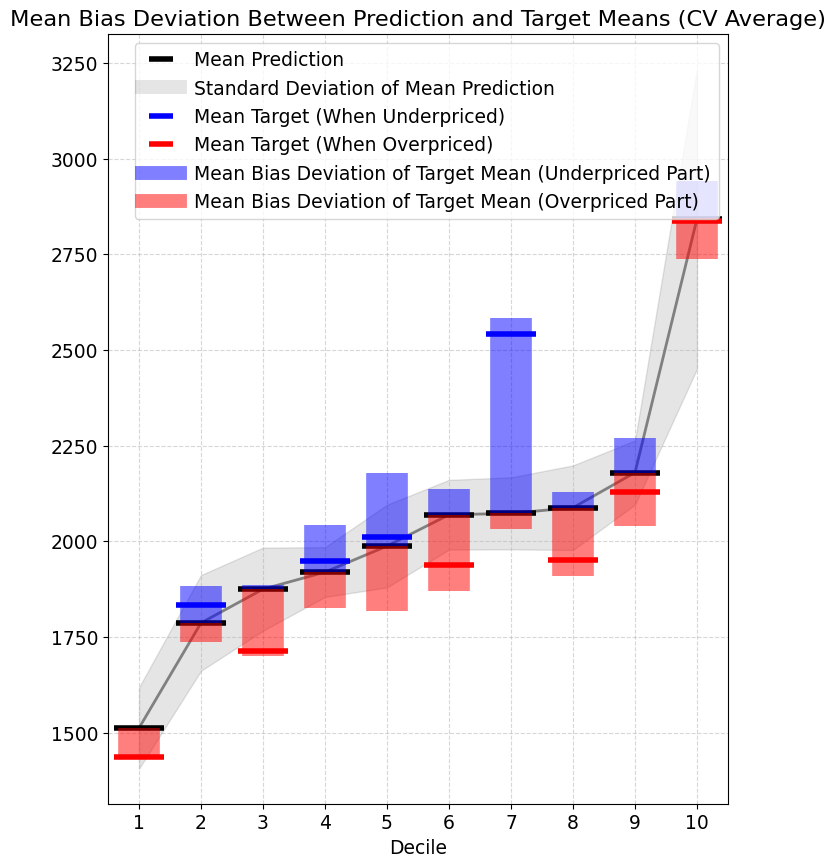

In [69]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
from typing import List


def plot_cv_mean_deviation_lines(
        summary_dfs: List[pd.DataFrame],
        min_val: float = None,
        max_val: float = None,
        interpolate_pred_mean: bool = True
) -> plt.Figure:
    all_groups = sorted(set(summary_dfs[0]["group"]))
    mean_pred = []
    mean_target = []
    std_pred = []
    red_heights = []
    blue_heights = []

    vline_width = np.interp([len(all_groups)], [1, 3, 7, 10, 20, 100], [100, 70, 40, 30, 10, 3])[0]

    for group in all_groups:
        pred_vals, target_vals, red_parts, blue_parts = [], [], [], []
        for df in summary_dfs:
            row = df[df["group"] == group]
            pred = row["mean_pred"].values[0]
            target = row["mean_target"].values[0]
            pred_vals.append(pred)
            target_vals.append(target)
            red_parts.append(max(0, pred - target))
            blue_parts.append(max(0, target - pred))
            # if pred >= target:
            #     red_parts.append(pred - target)
            # if pred <= target:
            #     blue_parts.append(target - pred)
        mean_pred.append(np.mean(pred_vals))
        mean_target.append(np.mean(target_vals))
        std_pred.append(np.std(pred_vals))
        red_heights.append(np.mean(red_parts) if len(red_parts) > 0 else 0)
        blue_heights.append(np.mean(blue_parts) if len(blue_parts) > 0 else 0)

    fig, ax = plt.subplots(figsize=(8, 10))

    # Mean prediction
    if interpolate_pred_mean:
        ax.plot(all_groups, mean_pred, color="black", linewidth=3)
    else:
        ax.plot(all_groups, mean_pred, color="gray", linewidth=2)
        for i, group in enumerate(all_groups):
            ax.hlines(y=mean_pred[i], xmin=group - 0.4, xmax=group + 0.4, color="black", linewidth=4, label=None)

    # Standard deviation band
    if len(summary_dfs) > 1:
        ax.fill_between(all_groups, np.array(mean_pred) - std_pred, np.array(mean_pred) + std_pred,
                        color="black", alpha=0.1)

    # Over/under bars
    for i, group in enumerate(all_groups):
        base = mean_pred[i]
        if red_heights[i] > 0:
            ax.vlines(group, ymin=base - red_heights[i], ymax=base, color="red", linewidth=vline_width, alpha=0.5)
        if blue_heights[i] > 0:
            ax.vlines(group, ymin=base, ymax=base + blue_heights[i], color="blue", linewidth=vline_width, alpha=0.5)

        # Mean target as a horizontal line
        target_y = mean_target[i]
        if target_y > base:
            marker_color = "blue"
        elif target_y < base:
            marker_color = "red"
        else:
            marker_color = "black"
        ax.hlines(y=target_y, xmin=group - 0.4, xmax=group + 0.4, color=marker_color, linewidth=4)

    # X-axis: grid every 1, labels every 5 (if many groups)
    ax.set_xticks(all_groups)
    if len(all_groups) > 25:
        xtick_labels = [str(g) if g % 5 == 0 or g == 1 else "" for g in all_groups]
    else:
        xtick_labels = [str(g) for g in all_groups]
    ax.set_xticklabels(xtick_labels)
    ax.set_xlim(min(all_groups) - 0.5, max(all_groups) + 0.5)

    # Set axis limits
    if min_val is not None or max_val is not None:
        ax.set_ylim(min_val, max_val)

    # Add labels, title, and legend
    match len(all_groups):
        case 10:
            xlabel = "Decile"
        case 100:
            xlabel = "Percentile"
        case _:
            xlabel = "Group"
    ax.set_xlabel(xlabel)
    title = "Bias Deviation Between Prediction and Target Means"
    if len(summary_dfs) > 1:
        title = f"Mean {title} (CV Average)"
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.5)

    label_dev_template = "Mean Bias Deviation of Target Mean ({kind} Part)" if len(
        summary_dfs) > 1 else "Bias Deviation of Target Mean (When {kind})"
    # Legend
    legend_handles = []
    if not interpolate_pred_mean:
        legend_handles.append(
            Line2D([0], [0], color='black', marker='_', markersize=17, markeredgewidth=4, linestyle='None',
                   label="Mean Prediction"))
    else:
        legend_handles.append(Line2D([0], [0], color="black", linewidth=4, label="Mean Prediction"))
    if len(summary_dfs) > 1:
        legend_handles.append(Line2D([0], [0], color="black", linewidth=min(vline_width, 10), alpha=0.1,
                                     label="Standard Deviation of Mean Prediction")),

    legend_handles = legend_handles + [
        Line2D([0], [0], color='blue', marker='_', markersize=17, markeredgewidth=4, linestyle='None',
               label="Mean Target (When Underpriced)"),
        Line2D([0], [0], color='red', marker='_', markersize=17, markeredgewidth=4, linestyle='None',
               label="Mean Target (When Overpriced)"),
        Line2D([0], [0], color="blue", linewidth=min(vline_width, 10), alpha=0.5,
               label=label_dev_template.format(kind="Underpriced")),
        Line2D([0], [0], color="red", linewidth=min(vline_width, 10), alpha=0.5,
               label=label_dev_template.format(kind="Overpriced")),
    ]

    ax.legend(handles=legend_handles)
    plt.close(fig)
    return fig


summary_dfs = [prediction_group_summary_strict_bins(y_true=df_trg.ClaimSeverity_TRG, y_pred = df_pred.ClaimSeverity_PRED, sample_weight=df_trg.ClaimNb_TRG, round_precision=0, as_int=True, n_bins=10)
               for df_pred, df_trg in zip(calib_predictions_df.values(), calib_target_df.values())]
# summary_dfs = summary_dfs[:1]
plot_cv_mean_deviation_lines(summary_dfs, interpolate_pred_mean=False)

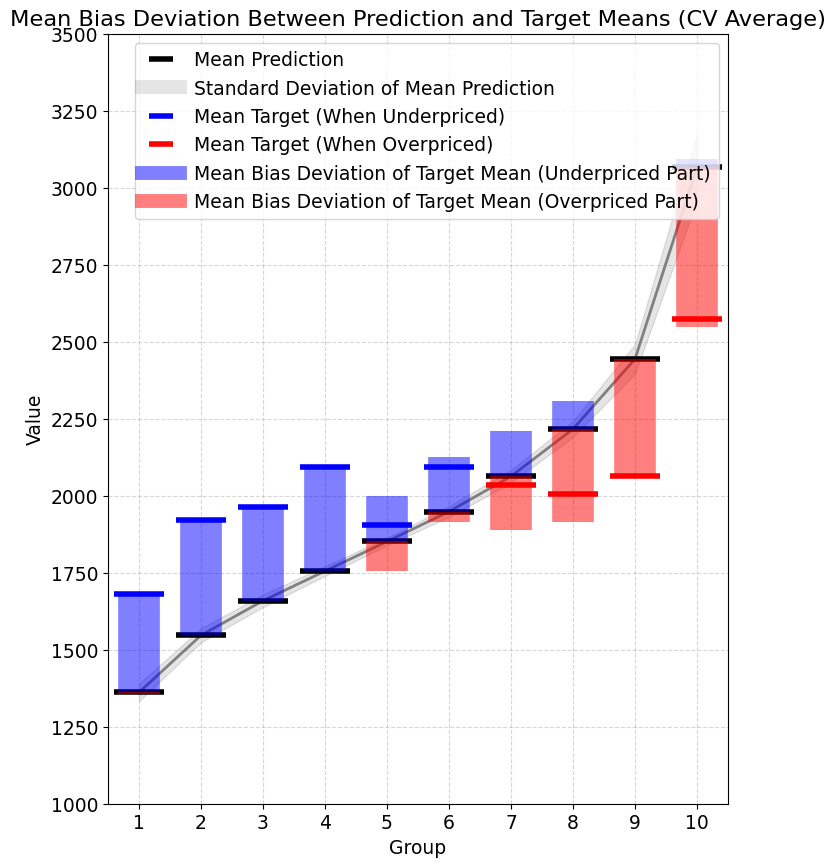

In [61]:
summary_dfs = [prediction_group_summary_strict_bins(y_true=df_trg.ClaimSeverity_TRG, y_pred = df_pred.pure_ClaimSeverity_PRED, sample_weight=df_trg.ClaimNb_TRG, round_precision=0, as_int=True, n_bins=10)
               for df_pred, df_trg in zip(calib_predictions_df.values(), calib_target_df.values())]
plot_cv_mean_deviation_lines(summary_dfs, interpolate_pred_mean=False)

## Simple lift plot

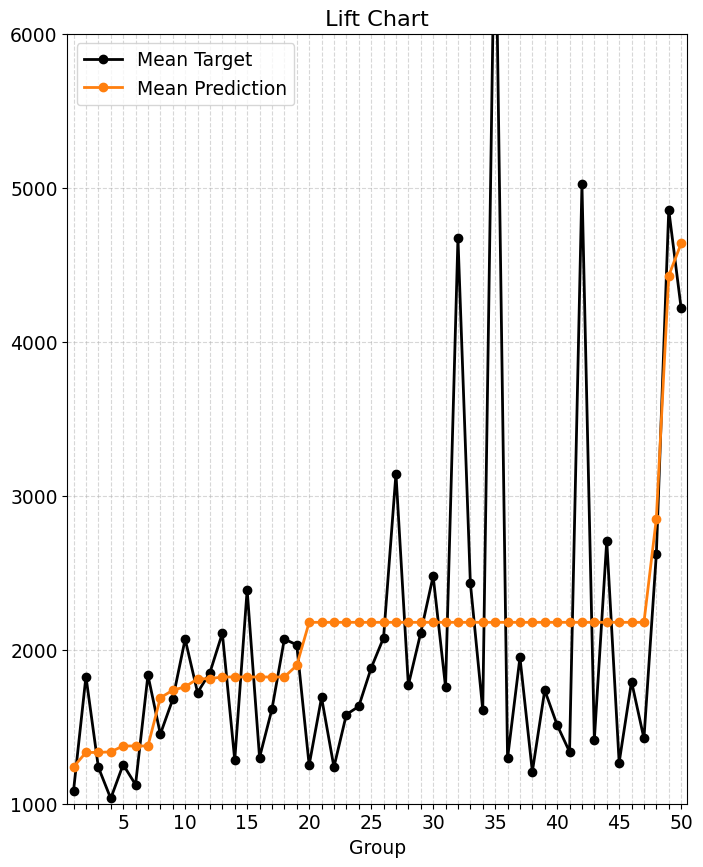

In [108]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


def plot_cv_mean_simple_lift_chart(
        summary_dfs: List[pd.DataFrame],
        min_val: float = None,
        max_val: float = None,
        show_std_band: bool = True,
        marker: str = "o",
) -> plt.Figure:
    """
    Plots a minimalist lift chart with mean prediction and target lines,
    optionally showing standard deviation bands.

    Args:
        summary_dfs (List[pd.DataFrame]): List of summary DataFrames with "group", "mean_pred", and "mean_target" columns.
        min_val (float, optional): Minimum value for the y-axis. Defaults to None.
        max_val (float, optional): Maximum value for the y-axis. Defaults to None.
        show_std_band (bool, optional): Whether to show standard deviation bands. Defaults to True.

    Returns:
        plt.Figure: The generated matplotlib figure.
    """
    all_groups = sorted(set(summary_dfs[0]["group"]))
    mean_pred = []
    mean_target = []
    std_pred = []
    std_target = []

    for group in all_groups:
        pred_vals = []
        target_vals = []
        for df in summary_dfs:
            row = df[df["group"] == group]
            pred_vals.append(row["mean_pred"].values[0])
            target_vals.append(row["mean_target"].values[0])
        mean_pred.append(np.mean(pred_vals))
        mean_target.append(np.mean(target_vals))
        if len(summary_dfs) > 1:
            std_pred.append(np.std(pred_vals))
            std_target.append(np.std(target_vals))

    fig, ax = plt.subplots(figsize=(8, 10))

    linewidth=2
    target_color = "black"
    pred_color = "tab:orange"


    # Plot standard deviation band if applicable
    if show_std_band and len(summary_dfs) > 1:
        ax.fill_between(all_groups, np.array(mean_target) - std_target, np.array(mean_target) + std_target,
                        color=target_color, alpha=0.1)
    # Plot mean target line
    ax.plot(all_groups, mean_target, color=target_color, marker=marker, linewidth=linewidth)

    # Plot standard deviation band if applicable
    if show_std_band and len(summary_dfs) > 1:
        ax.fill_between(all_groups, np.array(mean_pred) - std_pred, np.array(mean_pred) + std_pred,
                        color=pred_color, alpha=0.1)
    # Plot mean prediction line
    ax.plot(all_groups, mean_pred, color=pred_color, marker=marker, linewidth=linewidth)

    ax.set_xticks(all_groups)
    if len(all_groups) > 20:
        xtick_labels = [str(g) if g % 5 == 0 else "" for g in all_groups]
    else:
        xtick_labels = [str(g) for g in all_groups]
    ax.set_xticklabels(xtick_labels)
    ax.set_xlim(min(all_groups) - 0.5, max(all_groups) + 0.5)

    # Set axis limits
    if min_val is not None or max_val is not None:
        ax.set_ylim(min_val, max_val)

    # Add labels, title, and legend
    match len(all_groups):
        case 10:
            xlabel = "Decile"
        case 100:
            xlabel = "Percentile"
        case _:
            xlabel = "Group"
    ax.set_xlabel(xlabel)

    title = "Lift Chart"
    if len(summary_dfs) > 1:
        title = f"Mean {title} (CV Average)"
    ax.set_title(title)

    legend_handles = [
        Line2D([0], [0], color=target_color, marker=marker, linewidth=linewidth, label="Mean Target"),
        Line2D([0], [0], color=pred_color, marker=marker, linewidth=linewidth, label="Mean Prediction"),
    ]
    if show_std_band and len(summary_dfs) > 1: 
        legend_handles = legend_handles + [
            Patch(facecolor=target_color, alpha=0.1, label="Standard Deviation of Target Mean"),
            Patch(facecolor=pred_color, alpha=0.1, label="Standard Deviation of Prediction Mean"),
        ]
    ax.legend(handles=legend_handles)
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.close(fig)
    return fig



summary_dfs = [prediction_group_summary_strict_bins(y_true=df_trg.ClaimSeverity_TRG, y_pred = df_pred.ClaimSeverity_PRED, sample_weight=df_trg.ClaimNb_TRG, round_precision=0, as_int=True, n_bins=50)
               for df_pred, df_trg in zip(calib_predictions_df.values(), calib_target_df.values())]
summary_dfs = summary_dfs[:1]
plot_cv_mean_simple_lift_chart(summary_dfs, show_std_band=True, marker="o", min_val=1000, max_val=6000)

## Cumulative Percentile Statistics

In [411]:
import pandas as pd
import numpy as np

def cumulative_percentile_statistics(
    y_true: pd.Series,
    y_pred: pd.Series,
    sample_weight: pd.Series = None,
    percentiles: list = None,
    task_name: str = "Metric",
    ascending: bool = True,
):
    """
    Calculate cumulative statistics across percentiles for weighted predictions and actual values.

    Args:
        y_true (pd.Series): Actual target values (severity, frequency, or pure premium).
        y_pred (pd.Series): Predicted target values.
        sample_weight (pd.Series, optional): Observation weights. Defaults to equal weight.
        percentiles (list, optional): List of percentiles to calculate. Defaults to [10, 20, ..., 99].
        task_name (str): Name of the task (e.g., "Severity", "Frequency").

    Returns:
        pd.DataFrame: Cumulative statistics across percentiles with Cumulative Lift.
    """
    if percentiles is None:
        percentiles = list(range(10, 100, 10)) + [99]

    # Initialize equal weights if none are provided
    if sample_weight is None:
        sample_weight = pd.Series(np.ones_like(y_true), index=y_true.index)

    # Combine inputs into a single DataFrame
    data = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'weight': sample_weight
    })

    # Sort by predicted values (descending)
    data_sorted = data.sort_values(by='y_pred', ascending=ascending).reset_index(drop=True)

    # Calculate the total weighted true response
    total_weighted_true = np.sum(data_sorted['y_true'] * data_sorted['weight'])

    results = []

    for perc in sorted(percentiles, reverse = not ascending):
        if ascending:
            cutoff = int(np.ceil(len(data_sorted) * ((perc + 1) / 100)))
        else:
            cutoff = int(np.ceil(len(data_sorted) * ((100 - perc) / 100)))
        subset = data_sorted.iloc[:cutoff]

        # Weighted sums and averages
        weighted_sum = np.sum(subset['weight'])
        weighted_pred_avg = np.average(subset['y_pred'], weights=subset['weight'])
        weighted_true_avg = np.average(subset['y_true'], weights=subset['weight'])

        # Cumulative captured response
        cum_captured_response = np.sum(subset['y_true'] * subset['weight']) / total_weighted_true

        # Cumulative lift calculation
        if ascending:
            expected_response = (perc + 1) / 100
        else:
            expected_response = (100 - perc) / 100  # Expected response under random selection
        cum_lift = cum_captured_response / expected_response if expected_response > 0 else np.nan

        results.append({
            'Percentile': f'{perc}',
            'Number of Observations': weighted_sum,
            f'Weighted Predicted Avg {task_name}': weighted_pred_avg,
            f'Weighted True Avg {task_name}': weighted_true_avg,
            'Cumulative Captured Response': cum_captured_response,
            'Cumulative Lift': cum_lift
        })

    # Convert results to DataFrame
    stats_df = pd.DataFrame(results)

    return stats_df


In [51]:
percentiles = list(range(0, 10)) + list(range(10, 90, 10)) + list(range(90, 100))

In [52]:
df = cumulative_percentile_statistics(y_true=test_target_df['0'].ClaimSeverity_TRG, y_pred = test_predictions_df["0"].ClaimSeverity_PRED, sample_weight=test_target_df['0'].ClaimNb_TRG, percentiles = percentiles, task_name="Severity",
                                     ascending=True)
df

Percentile  Number of Observations  Weighted Predicted Avg Severity  \
0           0                      53                      1141.707063   
1           1                     105                      1236.292842   
2           2                     158                      1268.631140   
3           3                     211                      1284.723658   
4           4                     261                      1293.914064   
5           5                     315                      1300.562667   
6           6                     366                      1305.040482   
7           7                     420                      1308.596395   
8           8                     470                      1311.977797   
9           9                     521                      1318.184786   
10         10                     574                      1323.466472   
11         20                    1105                      1458.790344   
12         30                    1634                      1575.281602   
13         40                    2167                      1652.918783   
14         50                    2701                      1756.645588   
15         60                    3238                      1826.453733   
16         70                    3771                      1876.081768   
17         80                    4300                      1913.172373   
18         90                    4811                      1941.255815   
19         91                    4861                      1943.686576   
20         92                    4911                      1946.067841   
21         93                    4963                      1948.493458   
22         94                    5015                      1950.868774   
23         95                    5065                      1953.643808   
24         96                    5122                      1971.923987   
25         97                    5181                      2001.041123   
26         98                    5235                      2027.115461   
27         99                    5288                      2052.189110   

    Weighted True Avg Severity  Cumulative Captured Response  Cumulative Lift  
0                  1358.251321                      0.006786         0.678556  
1                  1173.595905                      0.011615         0.580774  
2                  1262.813861                      0.018807         0.626909  
3                  1278.275403                      0.025424         0.635589  
4                  1222.806398                      0.030083         0.601669  
5                  1179.625937                      0.035026         0.583758  
6                  1150.183552                      0.039681         0.566865  
7                  1259.627881                      0.049868         0.623349  
8                  1757.808426                      0.077875         0.865280  
9                  1754.783090                      0.086177         0.861769  
10                 1807.720958                      0.097808         0.889161  
11                 1874.005529                      0.195192         0.929487  
12                 1893.854976                      0.291695         0.940950  
13                 1781.942017                      0.363984         0.887765  
14                 1544.411818                      0.393203         0.770987  
15                 1371.899561                      0.418725         0.686434  
16                 1397.432803                      0.496726         0.699614  
17                 2104.537453                      0.853011         1.053100  
18                 2004.065546                      0.908818         0.998701  
19                 1995.711232                      0.914435         0.993951  
20                 1987.557935                      0.920067         0.989319  
21                 1979.112053                      0.925858         0.984955  
22              

In [67]:
df = cumulative_percentile_statistics(y_true=test_target_df['0'].ClaimSeverity_TRG, y_pred = test_predictions_df["0"].ClaimSeverity_PRED, sample_weight=test_target_df['0'].ClaimNb_TRG, percentiles = percentiles, task_name="Severity",
                                     ascending=False)
df

Percentile  Number of Observations  Weighted Predicted Avg Severity  \
0          99                      25                      8172.867143   
1          98                      53                      6479.954528   
2          97                      81                      5225.180213   
3          96                     107                      4615.188174   
4          95                     132                      4255.271543   
5          94                     161                      3977.800411   
6          93                     187                      3802.200019   
7          92                     212                      3673.972229   
8          91                     237                      3572.796716   
9          90                     266                      3479.258812   
10         80                     532                      3097.043587   
11         70                     792                      2971.568892   
12         60                    1051                      2908.299817   
13         50                    1310                      2870.048590   
14         40                    1568                      2844.508527   
15         30                    1831                      2797.521565   
16         20                    2096                      2674.159748   
17         10                    2358                      2569.597973   
18          9                    2384                      2560.192506   
19          8                    2409                      2551.340248   
20          7                    2435                      2542.326722   
21          6                    2461                      2533.503650   
22          5                    2487                      2524.865056   
23          4                    2514                      2516.083331   
24          3                    2542                      2506.720522   
25          2                    2567                      2497.797240   
26          1                    2593                      2485.761012   
27          0                    2618                      2474.413169   

    Weighted True Avg Severity  Cumulative Captured Response  Cumulative Lift  
0                  1291.708800                      0.004580         0.458022  
1                  1186.597547                      0.008920         0.445996  
2                  1206.588642                      0.013862         0.462067  
3                  1407.569346                      0.021362         0.534042  
4                  1376.511061                      0.025771         0.515425  
5                  1489.990248                      0.034024         0.567074  
6                  1527.123636                      0.040504         0.578628  
7                  1446.671509                      0.043500         0.543748  
8                  1640.498608                      0.055145         0.612722  
9                  1630.821090                      0.061528         0.615276  
10                 4206.176466                      0.317381         1.586905  
11                 3396.914419                      0.381585         1.271951  
12                 3763.118487                      0.560961         1.402402  
13                 3374.211038                      0.626939         1.253878  
14                 3128.673240                      0.695806         1.159676  
15                 3133.254571                      0.813703         1.162432  
16                 2950.561169                      0.877158         1.096447  
17                 2800.787774                      0.936711         1.040790  
18                 2788.097936                      0.942749         1.035988  
19                 2769.606584                      0.946317         1.028605  
20                 2754.605458                      0.951350         1.022957  
21                 2735.367351                      0.954793         1.015737  
22              

## Cumulative Calibration Index (CCI, COI, CUI)

In [412]:
def weighted_cumul_clb_areas(y_true: np.ndarray, y_pred: np.ndarray, sample_weight: np.ndarray = None) -> Tuple[float, float, float]:
    """
    ...
    """
    assert len(y_true) == len(y_pred), "y_true and y_pred must have the same length"
    y_true, y_pred, sample_weight = ordered_by_pred_and_hashed_index(y_true, y_pred, sample_weight)

    # Weighted cumulative sums
    weighted_true = y_true * sample_weight
    weighted_pred = y_pred * sample_weight

    # Normalize by total
    total_weighted_true = np.sum(weighted_true)
    total_weighted_pred = np.sum(weighted_pred)

    # Compute cumulative proportions
    cum_true = np.cumsum(weighted_true) / total_weighted_true
    cum_pred = np.cumsum(weighted_pred) / total_weighted_pred

    # Include the origin point (0, 0)
    cum_true = np.insert(cum_true, 0, 0)
    cum_pred = np.insert(cum_pred, 0, 0)

    # Compute the area under the minimum of line of equity and the cumulative calibration curve
    area_under_min_equity_and_curve = np.trapz(np.minimum(cum_true, cum_pred), cum_pred)

    # Compute the area under the maximum of line of equity and the cumulative calibration curve
    area_under_max_equity_and_curve = np.trapz(np.maximum(cum_true, cum_pred), cum_pred)

    # Compute the area over the line of equity and the capped calibration curve
    area_under_equity = np.trapz(cum_pred, cum_pred)

    return area_under_min_equity_and_curve, area_under_max_equity_and_curve, area_under_equity

In [413]:
def weighted_cumul_clb_idx(y_true: np.ndarray, y_pred: np.ndarray, sample_weight: np.ndarray = None):
    """
    Compute the Cumulative Calibration Index, which measures the inequality of true values distribution
    relative to predictions distributions.
    The Cumulative Calibration Index is defined as an integral of absolute values of the differences beetween cumulative calibration curve and the line of equity

    Args:
        y_true (np.ndarray): True values (e.g., claim amounts).
        y_pred (np.ndarray): Predicted values (e.g., premium values).
        sample_weight (np.ndarray or pd.Series, optional): Weights for observations. Defaults to None.

    Returns:
        float: Cumulative Calibration Index.
    """
    area_under_min_equity_and_curve, area_under_max_equity_and_curve, _ = weighted_cumul_clb_areas(y_true, y_pred, sample_weight)
    cci = area_under_max_equity_and_curve - area_under_min_equity_and_curve
    return cci

def weighted_overpricing_idx(y_true: np.ndarray, y_pred: np.ndarray, sample_weight: np.ndarray = None):
    """
    Compute the Cumulative Overpricing Index is defined as an integral of the positive differences beetween cumulative calibration curve and the line of equity

    Args:
        y_true (np.ndarray): True values (e.g., claim amounts).
        y_pred (np.ndarray): Predicted values (e.g., premium values).
        sample_weight (np.ndarray or pd.Series, optional): Weights for observations. Defaults to None.

    Returns:
        float: Cumulative Overpricing Index
    """
    area_under_min_equity_and_curve, _, area_under_equity = weighted_cumul_clb_areas(y_true, y_pred, sample_weight)
    coi = area_under_equity - area_under_min_equity_and_curve
    return coi


def weighted_underpricing_idx(y_true: np.ndarray, y_pred: np.ndarray, sample_weight: np.ndarray = None):
    """
    Compute the Cumulative Underpricing Index is defined as an integral of the positive differences beetween the line of equity and the cumulative calibration curve

    Args:
        y_true (np.ndarray): True values (e.g., claim amounts).
        y_pred (np.ndarray): Predicted values (e.g., premium values).
        sample_weight (np.ndarray or pd.Series, optional): Weights for observations. Defaults to None.

    Returns:
        float: Cumulative Overpricing Index
    """
    _, area_under_max_equity_and_curve, area_under_equity = weighted_cumul_clb_areas(y_true, y_pred, sample_weight)
    cui = area_under_max_equity_and_curve - area_under_equity
    return cui

In [441]:
weighted_cumul_clb_areas(df.ClaimSeverity_TRG, df.ClaimSeverity_PRED, df.ClaimNb_TRG)

(0.4915514313532843, 0.5047861089974199, 0.49999999999999223)

In [414]:
df.describe()

pure_ClaimSeverity_PRED  calibrated_ClaimSeverity_PRED  \
count              4987.000000                    4987.000000   
mean               1990.708852                    2078.335365   
std                 533.205980                     630.203858   
min                 987.269142                     761.325000   
25%                1668.498809                    1822.852985   
50%                1890.411338                    2177.574403   
75%                2168.720701                    2177.574403   
max                7081.912661                   16288.250000   

       ClaimSeverity_PRED  ClaimNb_TRG  ClaimFreq_TRG  ClaimSeverity_TRG  \
count         4987.000000  4987.000000    4987.000000        4987.000000   
mean          2078.335365     1.058753       3.268639        2000.124175   
std            630.203858     0.247647       9.786280        8941.319140   
min            761.325000     1.000000       1.000000           1.490000   
25%           1822.852985     1.000000       1.000000         710.020000   
50%           2177.574403     1.000000       1.351351        1172.000000   
75%           2177.574403     1.000000       2.424331        1226.405000   
max          16288.250000     4.000000     365.000000      300000.000000   

       ClaimTotalAmount_TRG  ClaimPurePremium_TRG     Exposure  
count          4.987000e+03          4.987000e+03  4987.000000  
mean           2.406399e+03          1.045531e+04     0.692216  
std            2.094788e+04          1.107724e+05     0.314956  
min            1.490000e+00          1.490000e+00     0.005479  
25%            7.500450e+02          1.128000e+03     0.440000  
50%            1.172000e+03          1.502564e+03     0.770000  
75%            1.342200e+03          3.418045e+03     1.000000  
max            1.301173e+06          4.066164e+06     1.000000

In [415]:
weighted_cumul_clb_areas(df.ClaimSeverity_TRG, df.ClaimSeverity_PRED, df.ClaimNb_TRG)

(0.4915514313532843, 0.5047861089974199, 0.49999999999999223)

In [429]:
weighted_cumul_clb_idx(df.ClaimSeverity_TRG, df.ClaimSeverity_PRED, df.ClaimNb_TRG)

0.013234677644135662

In [417]:
weighted_cumul_clb_idx(df.ClaimSeverity_TRG, df.pure_ClaimSeverity_PRED, df.ClaimNb_TRG)

0.026730609525038362

In [430]:
weighted_cumul_clb_idx(df.ClaimSeverity_TRG, np.ones_like(df.ClaimSeverity_TRG) * df.ClaimSeverity_TRG.mean(), df.ClaimNb_TRG)

0.016526858907401687

In [420]:
weighted_cumul_clb_idx(df.ClaimSeverity_TRG, df.ClaimSeverity_TRG, df.ClaimNb_TRG)

0.0

In [421]:
weighted_cumul_clb_idx(df.ClaimSeverity_TRG, df.ClaimSeverity_TRG.max() + 1000000 - df.ClaimSeverity_TRG, df.ClaimNb_TRG)

0.3019001256479663

In [422]:
weighted_overpricing_idx(df.ClaimSeverity_TRG, df.ClaimSeverity_PRED, df.ClaimNb_TRG)

0.008448568646707955

In [423]:
weighted_overpricing_idx(df.ClaimSeverity_TRG, df.pure_ClaimSeverity_PRED, df.ClaimNb_TRG)

0.0010175709375514486

In [424]:
weighted_overpricing_idx(df.ClaimSeverity_TRG, np.ones_like(df.ClaimSeverity_TRG), df.ClaimNb_TRG)

0.011656401039191966

In [425]:
weighted_overpricing_idx(df.ClaimSeverity_TRG, df.ClaimSeverity_TRG, df.ClaimNb_TRG)

0.0

In [426]:
weighted_underpricing_idx(df.ClaimSeverity_TRG, df.ClaimSeverity_PRED, df.ClaimNb_TRG)

0.004786108997427707

In [427]:
weighted_underpricing_idx(df.ClaimSeverity_TRG, df.pure_ClaimSeverity_PRED, df.ClaimNb_TRG)

0.025713038587486914

In [428]:
weighted_underpricing_idx(df.ClaimSeverity_TRG, np.ones_like(df.ClaimSeverity_TRG), df.ClaimNb_TRG)

0.004870457868214384

In [324]:
np.ones_like(df.ClaimSeverity_TRG)

array([1., 1., 1., ..., 1., 1., 1.])

In [308]:
weighted_underpricing_idx(df.ClaimSeverity_TRG, df.ClaimSeverity_TRG, df.ClaimNb_TRG)

0.0

## Cumulative Calibration Curve

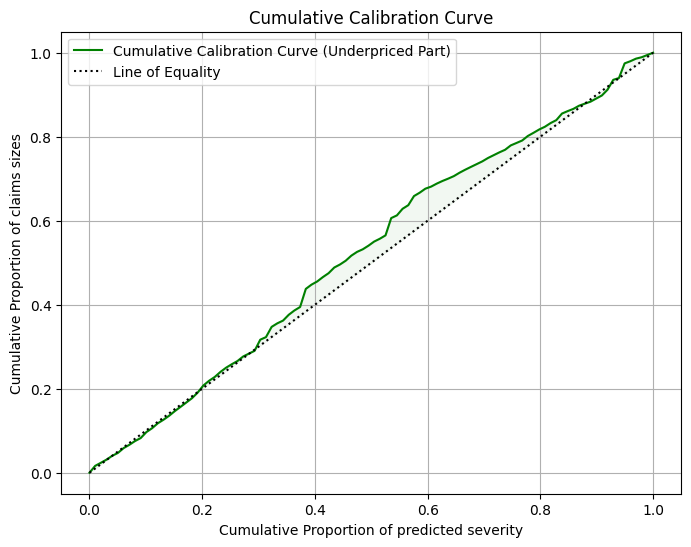

In [532]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def calculate_cumulative_calib_curve(y_true: pd.Series, y_pred: pd.Series, sample_weight: pd.Series = None):
    """
    Calculate the points for the Cumulative Calibration Curve.

    Args:
        y_true (pd.Series or pd.Series):
        y_pred (pd.Series or pd.Series):
        sample_weight (pd.Series or pd.Series, optional): Observation weights. Defaults to None.

    Returns:
        tuple: (x_points, y_points) for the Concentration Curve.
    """
    y_true, y_pred, sample_weight = ordered_by_pred_and_hashed_index(y_true, y_pred, sample_weight)

    # Weighted cumulative sums
    weighted_y_true = y_true * sample_weight
    weighted_y_pred = y_pred * sample_weight

    # Total sums for normalization
    total_y_true = weighted_y_true.sum()
    total_y_pred = weighted_y_pred.sum()

    # Cumulative sums
    cum_y_true = np.cumsum(weighted_y_true) / total_y_true
    cum_y_pred = np.cumsum(weighted_y_pred) / total_y_pred

    # Include the origin point (0, 0)
    cum_y_true = np.insert(cum_y_true, 0, 0)
    cum_y_pred = np.insert(cum_y_pred, 0, 0)

    return cum_y_pred, cum_y_true


def segment_intersects_y_eq_x(p0, p1):
    """
    Check if a line segment intersects the line y = x.

    Args:
        p0 (tuple): Starting point of the segment (x0, y0).
        p1 (tuple): Ending point of the segment (x1, y1).

    Returns:
        tuple or None: Intersection point (xi, yi) if the segment intersects y = x, otherwise None.
    """
    x0, y0 = p0
    x1, y1 = p1

    # Check if the segment crosses the line y = x (sign change check)
    f0 = y0 - x0
    f1 = y1 - x1

    if f0 * f1 >= 0:
        return None  # No intersection on the open segment

    # Parametric equation of the segment: x = x0 + t*(x1 - x0), y = y0 + t*(y1 - y0)
    # Solve for t where x = y -> x0 + t*(x1 - x0) = y0 + t*(y1 - y0)
    numerator = y0 - x0
    denominator = (x1 - x0) - (y1 - y0)
    if denominator == 0:
        return None  # Parallel to y = x or collinear
    t = numerator / denominator

    if 0 < t < 1:  # Only consider points inside the segment (not endpoints)
        xi = x0 + t * (x1 - x0)
        yi = y0 + t * (y1 - y0)
        return (xi, yi)
    else:
        return None


def plot_cumulative_calib_curve(
    y_true: pd.Series,
    y_pred: pd.Series,
    sample_weight: pd.Series = None,
    title: str = "Cumulative Calibration Curve",
    n_points: int = 100,
    fill_between_equity_and_curve: bool = True,
    over_and_under_colors: bool = True
) -> plt.Figure:
    """
    Plot the Cumulative Calibration Curve with optional overpricing and underpricing coloring.

    Args:
        y_true (pd.Series): True target values.
        y_pred (pd.Series): Predicted target values.
        sample_weight (Optional[pd.Series]): Weights for observations (optional).
        title (str): Title of the plot.
        n_points (int): Number of interpolation points for the curves.
        fill_between_equity_and_curve (bool): Whether to fill the area between the curve and the line of equality.
        over_and_under_colors (bool): Whether to color overpricing and underpricing parts differently.

    Returns:
        Figure: Matplotlib figure object.
    """
    x_interp = np.linspace(0, 1, n_points)
    fig, ax = plt.subplots(figsize=(8, 6))

    # Calculate the cumulative calibration curve
    x, y = calculate_cumulative_calib_curve(y_true, y_pred, sample_weight)
    y_interp = np.interp(x_interp, x, y)

    if over_and_under_colors:
        overpricing_parts = []
        underpricing_parts = []
        stack = [(x_interp[0], y_interp[0])]
        for i in range(len(x_interp) - 1):
            p0 = x_interp[i], y_interp[i]
            p1 = x_interp[i + 1], y_interp[i + 1]
            intersection = segment_intersects_y_eq_x(p0, p1)
            lays_on_eq = (p0[0] == p0[1] and p1[0] == p1[1])
            if lays_on_eq:
                ax.plot([p0[0], p1[0]], [p0[1], p1[1]], color="black")
                stack = []
            elif intersection is not None or p1[0] == p1[1] or i == len(x_interp) - 2:
                stack.append(intersection or p1)
                if p0[1] > p0[0]:  # Above the equality line
                    overpricing_parts.append(stack)
                else:  # Below the equality line
                    underpricing_parts.append(stack)
                stack = [intersection] if intersection is not None else []
            stack.append(p1)
        
        # Plot overpricing and underpricing parts
        for parts, color in zip([overpricing_parts, underpricing_parts], ["blue", "red"]):
            for part in parts:
                x = list(map(lambda p: p[0], part))
                y = list(map(lambda p: p[1], part))
                if fill_between_equity_and_curve:
                    ax.fill_between(x, y, x, color=color, alpha=0.05)
                ax.plot(x, y, color=color)
        legend_handles = [
            Line2D([0], [0], color="blue", label="Cumulative Calibration Curve (Underpriced Part)"),
            Line2D([0], [0], color="red", label="Cumulative Calibration Curve (Overpriced Part)"),
        ]
    else:
        # Plot the curve without over/under coloring
        if fill_between_equity_and_curve:
            ax.fill_between(x_interp, y_interp, y2=x_interp, color="green", alpha=0.05)
        ax.plot(x_interp, y_interp, label="Cumulative Calibration Curve", color="green")
        legend_handles = [
            Line2D([0], [0], color="green", label="Cumulative Calibration Curve (Underpriced Part)"),
        ]
    
    # Plot the line of equality
    ax.plot([0, 1], [0, 1], label="Line of Equality", linestyle="dotted", color="black")
    legend_handles.append(Line2D([0], [0], color="black", linestyle="dotted", label="Line of Equality"))
    
    # Set axis labels, title, and legend
    ax.set_xlabel("Cumulative Proportion of predicted severity")
    ax.set_ylabel("Cumulative Proportion of claims sizes")
    ax.set_title(title)
    ax.legend(handles=legend_handles)
    ax.grid(True)
    plt.close(fig)
    return fig


plot_cumulative_calib_curve(y_true=df.ClaimSeverity_TRG, y_pred = df.pure_ClaimSeverity_PRED, sample_weight=df.ClaimNb_TRG, n_points=100,
                            fill_between_equity_and_curve=True, over_and_under_colors=False)

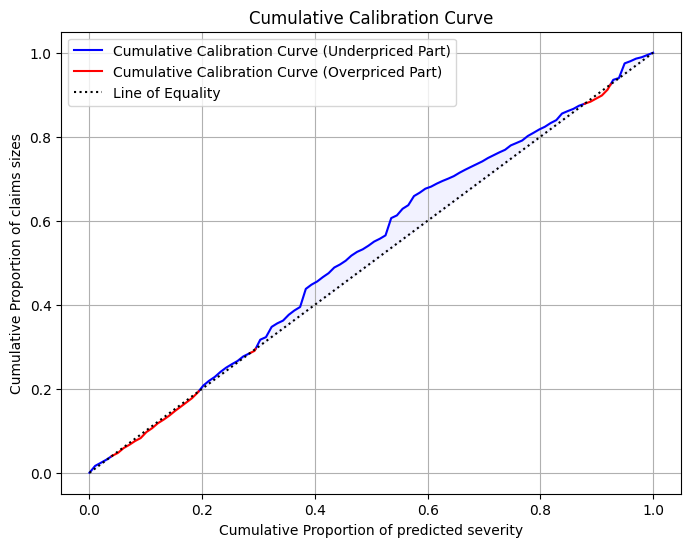

In [540]:
plot_cumulative_calib_curve(y_true=df.ClaimSeverity_TRG, y_pred = df.pure_ClaimSeverity_PRED, sample_weight=df.ClaimNb_TRG, n_points=100,
                            fill_between_equity_and_curve= True, over_and_under_colors=True)

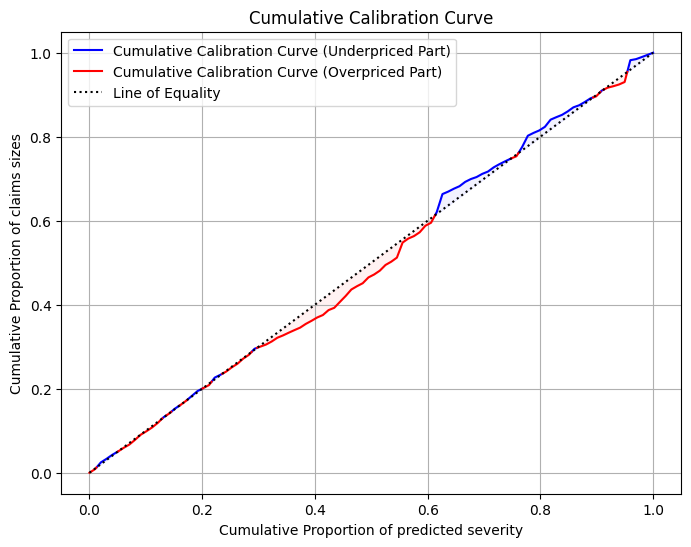

In [525]:
plot_cumulative_calib_curve(y_true=df.ClaimSeverity_TRG, y_pred = df.ClaimSeverity_PRED, sample_weight=df.ClaimNb_TRG, n_points=100, fill_between_equity_and_curve= True)

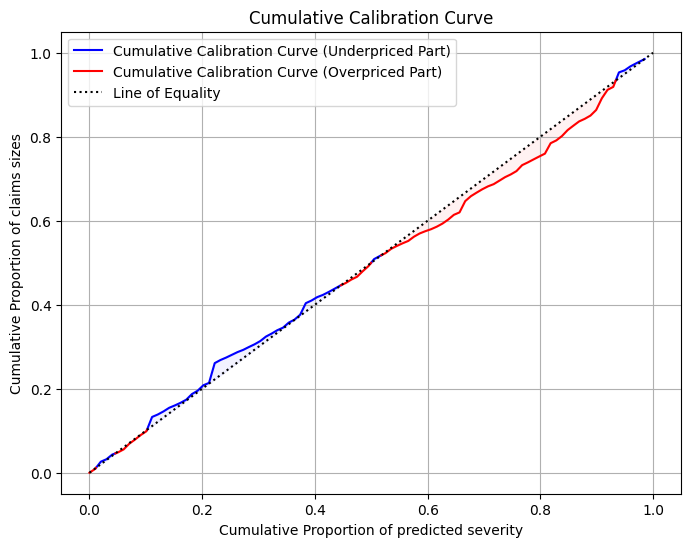

In [526]:
plot_cumulative_calib_curve(y_true=df.ClaimSeverity_TRG, y_pred = np.ones_like(df.ClaimSeverity_TRG), sample_weight=df.ClaimNb_TRG, n_points=100, fill_between_equity_and_curve= True)

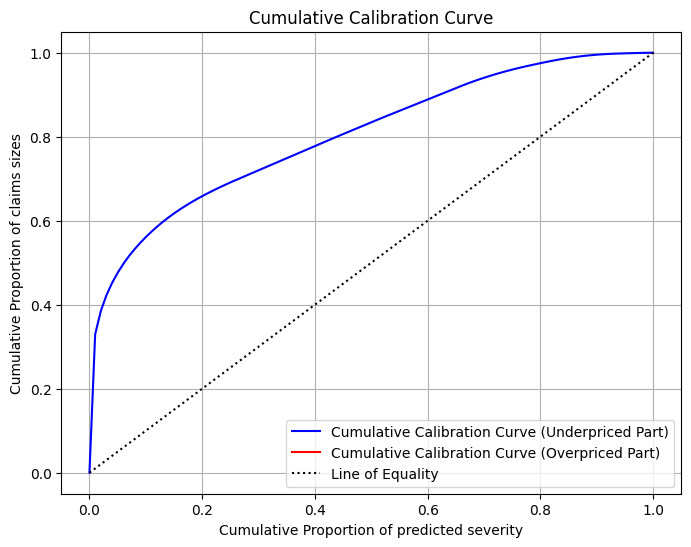

In [528]:
plot_cumulative_calib_curve(y_true=df.ClaimSeverity_TRG, y_pred = df.ClaimSeverity_TRG.max() + 1 - df.ClaimSeverity_TRG, sample_weight=df.ClaimNb_TRG, n_points=100, fill_between_equity_and_curve=False)

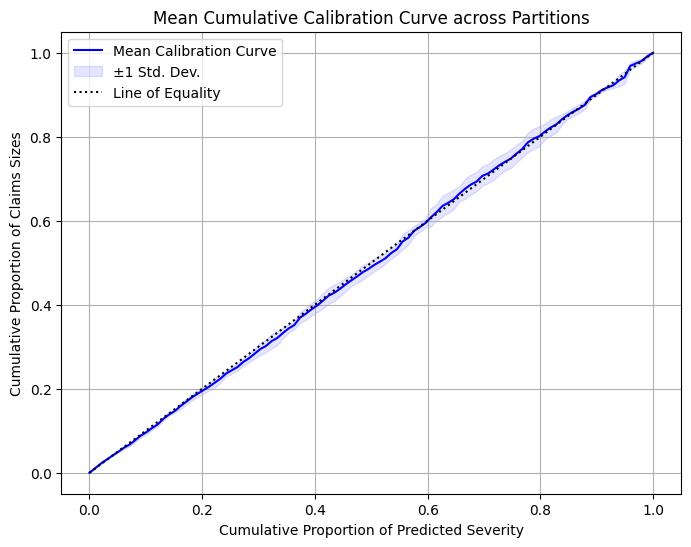

In [543]:
def plot_mean_cumulative_calib_curve(
    y_true_dict: Dict[str, pd.Series],
    y_pred_dict: Dict[str, pd.Series],
    sample_weight_dict: Dict[str, pd.Series] = None,
    title: str = "Mean Cumulative Calibration Curve across Partitions",
    fill_between_equity_and_curve: bool = False,
    over_and_under_colors: bool = False,
    show_std_band: bool = True,
    show_all_curves: bool = False,
    n_points: int = 100
) -> plt.Figure:
    """
    Generates a plot of the mean cumulative calibration curve across multiple partitions.

    Args:
        y_true_dict (Dict[str, pd.Series]): Dictionary of true target values for each partition.
        y_pred_dict (Dict[str, pd.Series]): Dictionary of predicted target values for each partition.
        sample_weight_dict (Dict[str, pd.Series], optional): Dictionary of sample weights for each partition. Defaults to None.
        title (str): Title of the plot.
        fill_between_equity_and_curve (bool): Whether to fill the area between the curve and the line of equality. Defaults to False.
        over_and_under_colors (bool): Whether to color overpricing and underpricing parts differently. Defaults to False.
        show_std_band (bool): Whether to display the standard deviation band around the mean curve. Defaults to True.
        show_all_curves (bool): Whether to display all individual curves for each partition. Defaults to False.
        n_points (int): Number of interpolation points for the curves. Defaults to 100.

    Returns:
        plt.Figure: A matplotlib figure object containing the mean cumulative calibration curve plot.
    """
    x_interp = np.linspace(0, 1, n_points)
    y_interp_all = []

    fig, ax = plt.subplots(figsize=(8, 6))

    for part in y_true_dict:
        weights = sample_weight_dict.get(part) if sample_weight_dict else None
        x, y = calculate_cumulative_calib_curve(y_true_dict[part], y_pred_dict[part], weights)
        y_interp = np.interp(x_interp, x, y)
        y_interp_all.append(y_interp)
        if show_all_curves:
            plt.plot(x, y, label=f"Calibration Curve for {part}", alpha=0.3)

    if y_interp_all:
        y_interp_all = np.array(y_interp_all)
        mean_y = np.mean(y_interp_all, axis=0)
        std_y = np.std(y_interp_all, axis=0)
        ax.plot(x_interp, mean_y, label="Mean Calibration Curve", color="blue")
        if show_std_band:
            ax.fill_between(x_interp, mean_y - std_y, mean_y + std_y, color="blue", alpha=0.1, label="±1 Std. Dev.")
        if fill_between_equity_and_curve:
            ax.fill_between(x_interp, mean_y, y2=x_interp, color="blue", alpha=0.05)

    if over_and_under_colors:
        for i in range(len(x_interp) - 1):
            p0 = (x_interp[i], mean_y[i])
            p1 = (x_interp[i + 1], mean_y[i + 1])
            intersection = segment_intersects_y_eq_x(p0, p1)
            if intersection:
                if p0[1] > p0[0]:  # Overpricing
                    ax.fill_between([p0[0], intersection[0]], [p0[1], intersection[1]], [p0[0], intersection[0]], color="red", alpha=0.1)
                else:  # Underpricing
                    ax.fill_between([p0[0], intersection[0]], [p0[1], intersection[1]], [p0[0], intersection[0]], color="blue", alpha=0.1)

    ax.plot([0, 1], [0, 1], label="Line of Equality", linestyle="dotted", color="black")
    ax.set_xlabel("Cumulative Proportion of Predicted Severity")
    ax.set_ylabel("Cumulative Proportion of Claims Sizes")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    plt.close(fig)
    return fig


y_true_dict = {part: df.ClaimSeverity_TRG for part, df in calib_target_df.items()}
y_pred_dict = {part: df.ClaimSeverity_PRED for part, df in calib_predictions_df.items()}
sample_weight_dict = {part: df.ClaimNb_TRG for part, df in calib_target_df.items()}
plot_mean_cumulative_calib_curve(y_true_dict, y_pred_dict, sample_weight_dict, show_all_curves=False, over_and_under_colors=True)

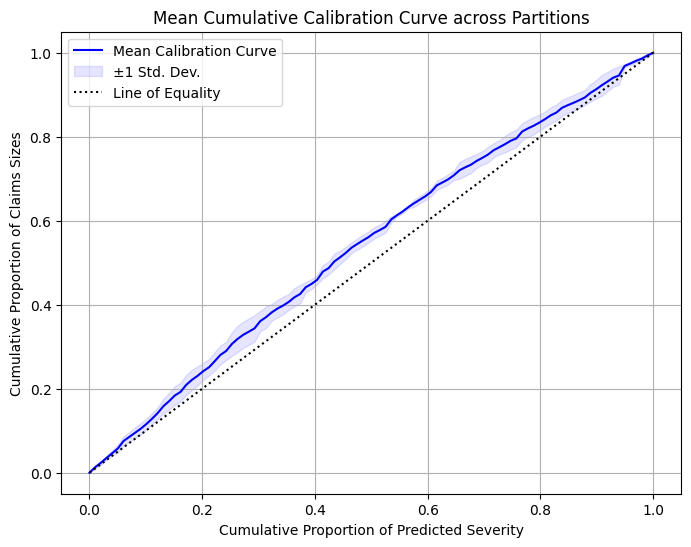

In [536]:
y_true_dict = {part: df.ClaimSeverity_TRG for part, df in calib_target_df.items()}
y_pred_dict = {part: df.pure_ClaimSeverity_PRED for part, df in calib_predictions_df.items()}
sample_weight_dict = {part: df.ClaimNb_TRG for part, df in calib_target_df.items()}
plot_mean_cumulative_calib_curve(y_true_dict, y_pred_dict, sample_weight_dict)

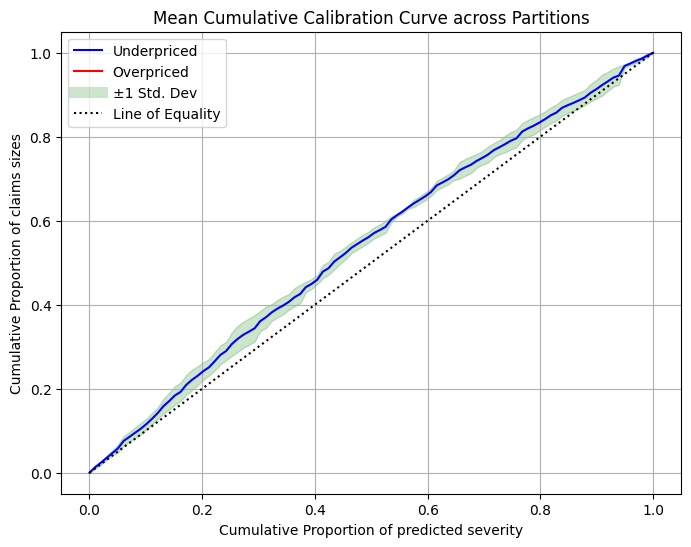

In [562]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from typing import Dict, Optional
import pandas as pd

def plot_mean_cumulative_calib_curve(
    y_true_dict: Dict[str, pd.Series],
    y_pred_dict: Dict[str, pd.Series],
    sample_weight_dict: Optional[Dict[str, pd.Series]] = None,
    title: str = "Mean Cumulative Calibration Curve across Partitions",
    fill_between_equity_and_curve: bool = False,
    over_and_under_colors: bool = False,
    show_std_band: bool = True,
    show_all_curves: bool = False,
    n_points: int = 100
) -> plt.Figure:
    x_interp = np.linspace(0, 1, n_points)
    y_interp_all = []

    fig, ax = plt.subplots(figsize=(8, 6))

    for part in y_true_dict:
        weights = sample_weight_dict.get(part) if sample_weight_dict else None
        x, y = calculate_cumulative_calib_curve(y_true_dict[part], y_pred_dict[part], weights)
        y_interp = np.interp(x_interp, x, y)
        y_interp_all.append(y_interp)

        if show_all_curves:
            ax.plot(x, y, alpha=0.3, label=f"Partition {part}")

    y_interp_all = np.array(y_interp_all)
    mean_y = np.mean(y_interp_all, axis=0)
    std_y = np.std(y_interp_all, axis=0)

    if over_and_under_colors:
        from itertools import tee
        def segment_intersects_y_eq_x(p0, p1):
            x0, y0 = p0
            x1, y1 = p1
            f0 = y0 - x0
            f1 = y1 - x1
            if f0 * f1 >= 0:
                return None
            denom = (x1 - x0) - (y1 - y0)
            if denom == 0:
                return None
            t = (y0 - x0) / denom
            if 0 < t < 1:
                xi = x0 + t * (x1 - x0)
                yi = y0 + t * (y1 - y0)
                return (xi, yi)
            return None

        overpricing_parts = []
        underpricing_parts = []
        stack = [(x_interp[0], mean_y[0])]
        for i in range(len(x_interp) - 1):
            p0 = x_interp[i], mean_y[i]
            p1 = x_interp[i + 1], mean_y[i + 1]
            intersection = segment_intersects_y_eq_x(p0, p1)
            lays_on_eq = (p0[0] == p0[1] and p1[0] == p1[1])
            if lays_on_eq:
                ax.plot([p0[0], p1[0]], [p0[1], p1[1]], color="black")
                stack = []
            elif intersection is not None or p1[0] == p1[1] or i == len(x_interp) - 2:
                stack.append(intersection or p1)
                if p0[1] > p0[0]:
                    overpricing_parts.append(stack)
                else:
                    underpricing_parts.append(stack)
                stack = [intersection] if intersection is not None else []
            stack.append(p1)

        for parts, color, label in zip([overpricing_parts, underpricing_parts], ["blue", "red"],
                                       ["Underpriced", "Overpriced"]):
            for part in parts:
                x = [p[0] for p in part]
                y = [p[1] for p in part]
                if fill_between_equity_and_curve:
                    ax.fill_between(x, y, x, color=color, alpha=0.05)
                ax.plot(x, y, color=color)

        legend_handles = [
            Line2D([0], [0], color="blue", label="Underpriced"),
            Line2D([0], [0], color="red", label="Overpriced")
        ]
    else:
        ax.plot(x_interp, mean_y, color="green", label="Mean Calibration Curve")
        if fill_between_equity_and_curve:
            ax.fill_between(x_interp, mean_y, y2=x_interp, color="green", alpha=0.05)
        legend_handles = [Line2D([0], [0], color="green", label="Mean Calibration Curve")]

    if show_std_band:
        color = "green"
        alpha = 0.2
        ax.fill_between(x_interp, mean_y - std_y, mean_y + std_y, color=color, alpha=alpha)
        legend_handles.append(Line2D([0], [0], color=color, alpha=alpha, linewidth=8, label="±1 Std. Dev"))

    ax.plot([0, 1], [0, 1], linestyle="dotted", color="black", label="Line of Equality")
    legend_handles.append(Line2D([0], [0], color="black", linestyle="dotted", label="Line of Equality"))

    ax.set_xlabel("Cumulative Proportion of predicted severity")
    ax.set_ylabel("Cumulative Proportion of claims sizes")
    ax.set_title(title)
    ax.legend(handles=legend_handles)
    ax.grid(True)
    plt.close(fig)
    return fig


y_true_dict = {part: df.ClaimSeverity_TRG for part, df in calib_target_df.items()}
y_pred_dict = {part: df.pure_ClaimSeverity_PRED for part, df in calib_predictions_df.items()}
sample_weight_dict = {part: df.ClaimNb_TRG for part, df in calib_target_df.items()}
plot_mean_cumulative_calib_curve(y_true_dict, y_pred_dict, sample_weight_dict, show_all_curves=False, over_and_under_colors=True)

## Auto-calibration Diagram

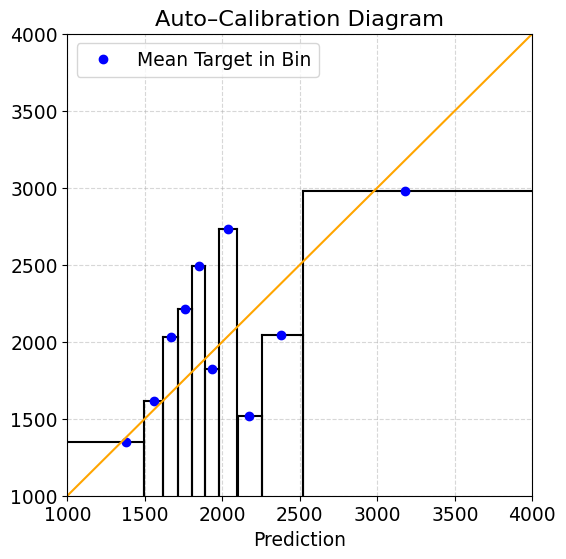

In [143]:
# Re-run after kernel reset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def plot_auto_calib_chart(
        y_true: pd.Series,
        y_pred: pd.Series,
        sample_weight: pd.Series,
        n_bins: int,
        min_x_val: float = None,
        max_x_val: float = None,
        min_y_val: float = None,
        max_y_val: float = None,
        marker: str = "o",
) -> plt.Figure:
    df = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
        "weight": sample_weight
    })

    # Sort by prediction
    df = df.sort_values("y_pred").reset_index(drop=True)

    # Assign decile bins
    df["bin"] = pd.qcut(df["y_pred"], q=n_bins, labels=False, duplicates="drop")

    bin_means_pred = df.groupby("bin").apply(lambda g: np.average(g["y_pred"], weights=g["weight"]))
    bin_means_true = df.groupby("bin").apply(lambda g: np.average(g["y_true"], weights=g["weight"]))
    bin_bounds = df.groupby("bin")["y_pred"].agg(["min", "max"])

    fig, ax = plt.subplots(figsize=(6, 6))

    # Histogram-style rectangles
    for i in range(len(bin_bounds)):
        xmin = bin_bounds.iloc[i]["min"]
        xmax = bin_bounds.iloc[i]["max"]
        y = bin_means_true.iloc[i]
        ax.plot([xmin, xmax], [y, y], color="black")
        ax.plot([xmin, xmin], [0, y], color="black")
        # if i < len(bin_bounds) - 1:
        ax.plot([xmax, xmax], [0, y], color="black")

    # Scatter of mean predictions vs mean true values
    ax.plot(bin_means_pred, bin_means_true, marker=marker, linestyle="", color="blue", label="Mean Target in Bin")

    # Diagonal line (perfect auto-calibration)
    low = min(min_x_val or 0, min_y_val or 0)
    high = max(max_x_val or df["y_pred"].max(), max_y_val or bin_means_true.max())
    ax.plot([low, high], [low, high], color="orange")

    # Axis limits
    if min_x_val is not None or max_x_val is not None:
        ax.set_xlim(left=min_x_val, right=max_x_val)
    if min_y_val is not None or max_y_val is not None:
        ax.set_ylim(bottom=min_y_val, top=max_y_val)

    ax.set_xlabel("Prediction")
    ax.set_title("Auto–Calibration Chart")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()
    plt.close(fig)
    return fig


# # Example synthetic test
# np.random.seed(0)
# n = 1000
# y_pred = pd.Series(np.random.gamma(shape=2.0, scale=20000, size=n))
# y_true = pd.Series(y_pred * np.random.uniform(0.5, 1.5, size=n))
# sample_weight = pd.Series(np.ones(n))

# plot_auto_calib_chart(y_true, y_pred, sample_weight)


y_true = df.ClaimSeverity_TRG
y_pred = df.pure_ClaimSeverity_PRED
sample_weight = df.ClaimNb_TRG
plot_auto_calib_chart(y_true, y_pred, sample_weight, n_bins=10, min_y_val = 1000, min_x_val=1000, max_y_val = 4000, max_x_val=4000)

In [146]:
np.mean([[]], axis=0)

array([], dtype=float64)

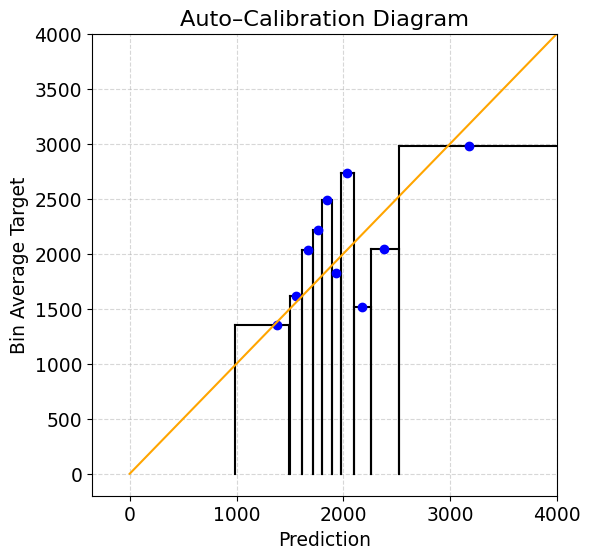

In [140]:
plot_auto_calib_chart(y_true, y_pred, sample_weight, n_bins=10, max_y_val = 4000, max_x_val=4000)

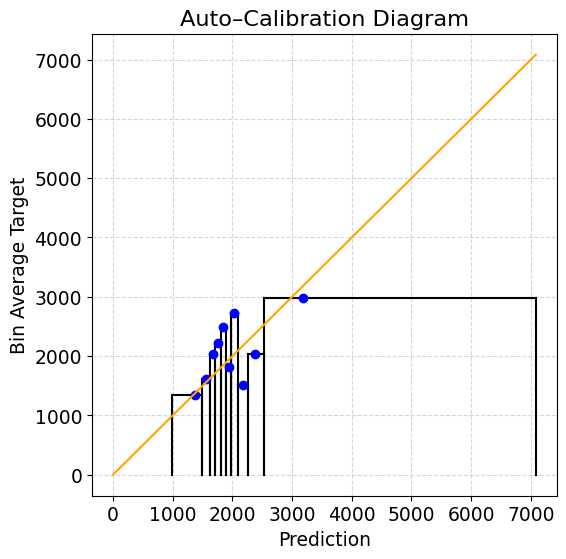

In [141]:
plot_auto_calib_chart(y_true, y_pred, sample_weight, n_bins=10)

## Calibration Curve

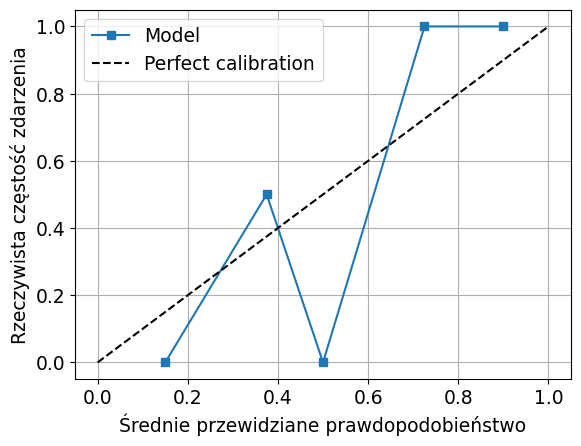

In [125]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

y_true = [0, 0, 1, 1, 1, 0, 1, 0]
y_prob = [0.1, 0.4, 0.35, 0.8, 0.9, 0.2, 0.65, 0.5]

fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_prob, n_bins=5)

plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
plt.xlabel("Średnie przewidziane prawdopodobieństwo")
plt.ylabel("Rzeczywista częstość zdarzenia")
plt.legend()
plt.grid()
plt.show()


In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_calibration_curve(y_true, y_pred, sample_weight=None, n_bins=10):
    """
    Plots a calibration curve with optional sample weighting.

    Args:
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values.
        sample_weight (array-like, optional): Weights for each observation.
        n_bins (int): Number of bins (e.g., 10 for deciles).
    """
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'sample_weight': sample_weight if sample_weight is not None else np.ones_like(y_true)
    })

    # Bin by predicted values (quantile bins)
    df['bin'] = pd.qcut(df['y_pred'], q=n_bins, duplicates='drop')

    # Compute weighted means per bin
    def weighted_mean(x):
        return np.average(x['y_true'], weights=x['sample_weight'])

    def weighted_pred(x):
        return np.average(x['y_pred'], weights=x['sample_weight'])

    grouped = df.groupby('bin').apply(
        lambda x: pd.Series({
            'mean_y_true': weighted_mean(x),
            'mean_y_pred': weighted_pred(x)
        })
    )

    # Plot calibration curve
    plt.plot(grouped['mean_y_pred'], grouped['mean_y_true'], marker='o', alpha=1, label='Calibration')
    min_val = min(grouped['mean_y_pred'].min(), grouped['mean_y_true'].min())
    max_val = max(grouped['mean_y_pred'].max(), grouped['mean_y_true'].max())

    plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray', label='Perfect calibration (y = x)')
    plt.xlabel("Mean Predicted")
    plt.ylabel("Mean Actual")
    plt.title("Calibration Curve (Weighted)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [127]:
pd.qcut(df.ClaimSeverity_PRED, q=100, duplicates='drop').value_counts().sort_index()

ClaimSeverity_PRED
(761.3240000000001, 1332.698]     389
(1332.698, 1375.386]              324
(1375.386, 1737.187]              255
(1737.187, 1811.075]              223
(1811.075, 1822.853]              684
(1822.853, 2177.574]             2863
(2177.574, 3537.708]               58
(3537.708, 4528.803]              190
(4528.803, 16288.25]                1
Name: count, dtype: int64

In [128]:
len(df)

4987

/tmp/ipykernel_4384/2673193972.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin').apply(


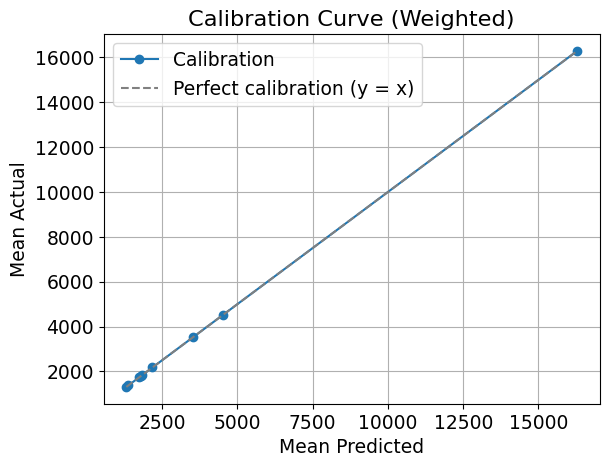

In [129]:
plot_calibration_curve(y_true=df.ClaimSeverity_TRG, y_pred=df.ClaimSeverity_PRED, sample_weight=df.ClaimNb_TRG, n_bins=100)

/tmp/ipykernel_4384/2673193972.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin').apply(


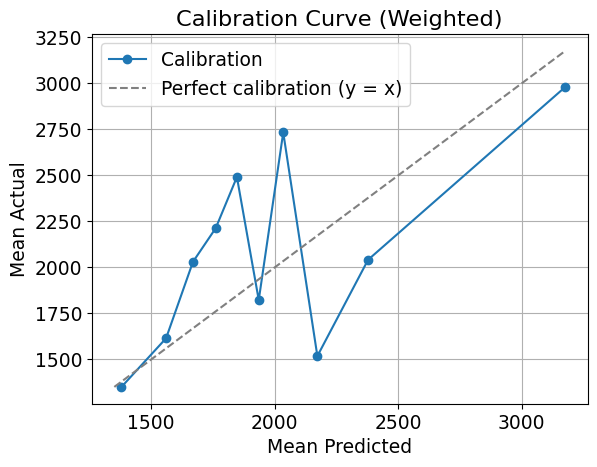

In [132]:
plot_calibration_curve(y_true=df.ClaimSeverity_TRG, y_pred=df.pure_ClaimSeverity_PRED, sample_weight=df.ClaimNb_TRG, n_bins=10)

In [131]:
plot_calibration_curve(y_true=test_target_df['0'].ClaimSeverity_TRG, y_pred=test_predictions_df["0"].pure_ClaimSeverity_PRED, sample_weight=test_target_df['0'].ClaimNb_TRG, n_bins=10)

NameError: name 'test_target_df' is not defined

/tmp/ipykernel_7549/2839208531.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin').apply(


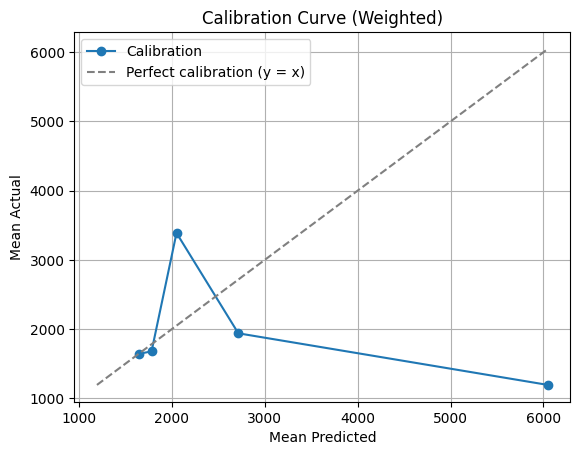

In [94]:
sv = test_target_df['0'].ClaimSeverity_TRG.copy()
sv[sv > 100000] = 100000
plot_calibration_curve(y_true=sv, y_pred=test_predictions_df["0"].ClaimSeverity_PRED, sample_weight=test_target_df['0'].ClaimNb_TRG, n_bins=10)

In [45]:
test_predictions_df["0"][index].columns

Index(['pure_ClaimSeverity_PRED', 'calibrated_ClaimSeverity_PRED',
       'ClaimSeverity_PRED'],
      dtype='object')

## EqualBinsMeansCalibration

In [11]:
from claim_modelling_kedro.pipelines.p01_init.config import Config
import yaml

with open("../conf/base/parameters.yml", "r") as f:
    parameters = yaml.safe_load(f)
config = Config(parameters)

In [45]:
import numpy as np
x = np.array([-1, -1, 0.2, 6.4, 3.0, 1.6, 5, 9, 11, 20])
bins = np.array([0.0, 1.0, 2.5, 4.0, 10.0])
inds = np.digitize(x, bins)
inds
# for n in range(x.size):
#     print(bins[inds[n]-1], "<=", x[n], "<", bins[inds[n]])

array([0, 0, 1, 4, 3, 2, 4, 4, 5, 5])

Fitted 10 bins: bounds=[ 987.26914206 1495.89662056 1616.45143621 1715.92424028 1803.40338091
 1890.41133756 1979.22207798 2097.87193454 2257.81986402 2522.01586292
 7081.91266071], means={0: 1350.8189883268483, 1: 1615.043619047619, 2: 2030.4112144212522, 3: 2213.217603773585, 4: 2493.6647628083488, 5: 1821.6195300751879, 6: 2733.3419999999996, 7: 1518.39763705104, 8: 2041.6110396975425, 9: 2980.156315789474}


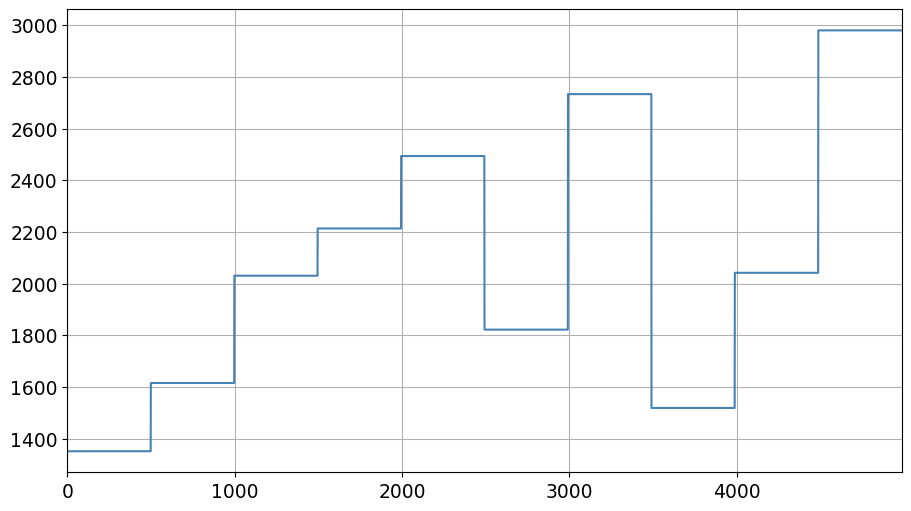

In [50]:
from typing import Dict, Any

import logging
import numpy as np
import pandas as pd
from hyperopt import hp

from claim_modelling_kedro.pipelines.p01_init.config import Config
from claim_modelling_kedro.pipelines.p07_data_science.model import get_sample_weight
from claim_modelling_kedro.pipelines.p08_model_calibration.calibration_model import CalibrationModel
from claim_modelling_kedro.pipelines.utils.dataframes import ordered_by_pred_and_hashed_index
from claim_modelling_kedro.pipelines.utils.metrics import RootMeanSquaredError


logger = logging.getLogger(__name__)


class EqualBinsMeansCalibration(CalibrationModel):
    def __init__(self, config: Config, **kwargs):
        super().__init__(config, **kwargs)

    def _fit(self, pure_predictions_df: pd.DataFrame, target_df: pd.DataFrame, **kwargs):
        logger.debug("EqualBinsMeansCalibration _fit called")
        sample_weight = get_sample_weight(config=self.config, target_df=target_df)
        y_true, y_pred, sample_weight = ordered_by_pred_and_hashed_index(
            target_df[self.target_col],
            pure_predictions_df[self.pure_pred_col],
            sample_weight
        )

        # Use qcut with duplicates='drop' to handle repeated prediction values
        try:
            _, self._bin_bounds = pd.qcut(
                y_pred,
                q=self._n_bins,
                labels=False,
                retbins=True,
                duplicates='drop'
            )
            self._n_bins = len(self._bin_bounds) - 1
        except ValueError as e:
            logger.warning(f"pd.qcut failed: {e}. Falling back to uniform binning.")
            self._bin_bounds = np.linspace(np.min(y_pred), np.max(y_pred), self._n_bins + 1)
        bin_indices = np.digitize(y_pred, self._bin_bounds[1:-1], right=False)

        # Compute means per bin
        self._bin_means = {}
        for bin_idx in range(self._n_bins):
            bin_mask = bin_indices == bin_idx
            if bin_mask.any():
                self._bin_means[bin_idx] = np.average(y_true[bin_mask], weights=sample_weight[bin_mask])

        # Global mean fallback
        self._global_mean = np.average(y_true, weights=sample_weight)

        logger.debug(f"Fitted {self._n_bins} bins: bounds={self._bin_bounds}, means={self._bin_means}")

    def _predict(self, pure_predictions_df: pd.DataFrame) -> pd.Series:
        logger.debug("EqualBinsMeansCalibration _predict called")
        y_pure_pred = pure_predictions_df[self.pure_pred_col].values
        bin_indices = np.digitize(y_pure_pred, self._bin_bounds[1:-1], right=False)
        calibrated = [self._bin_means.get(idx, self._global_mean) for idx in bin_indices]
        return pd.Series(calibrated, index=pure_predictions_df.index)

    def metric(self):
        return RootMeanSquaredError(self.config, pred_col=self.pred_col)

    @classmethod
    def get_default_hparams(cls) -> Dict[str, Any]:
        return {"n_bins": 10}

    @classmethod
    def get_hparams_space(cls) -> Dict[str, Any]:
        return {"n_bins": hp.quniform("n_bins", 2, 100, 1)}

    def get_params(self, deep: bool = True) -> Dict[str, Any]:
        return dict(config=self.config)

    def summary(self):
        return f"EqualBinsMeansCalibration with {self._n_bins} bins.\nBounds: {self._bin_bounds}\nMeans: {self._bin_means}"

    def _updated_hparams(self):
        self._bin_means = None
        if self._hparams is not None:
            self._n_bins = int(self._hparams.get("n_bins"))
        self._bin_bounds = None



ebmc = EqualBinsMeansCalibration(config, n_bins=10)
ebmc.fit(df, df)
clb_pred = ebmc.predict(df.sort_values("pure_ClaimSeverity_PRED"))
plot_ts(clb_pred.calibrated_ClaimSeverity_PRED.values)
# plot_ts(clb_pred.calibrated_ClaimSeverity_PRED.sort_values().values)

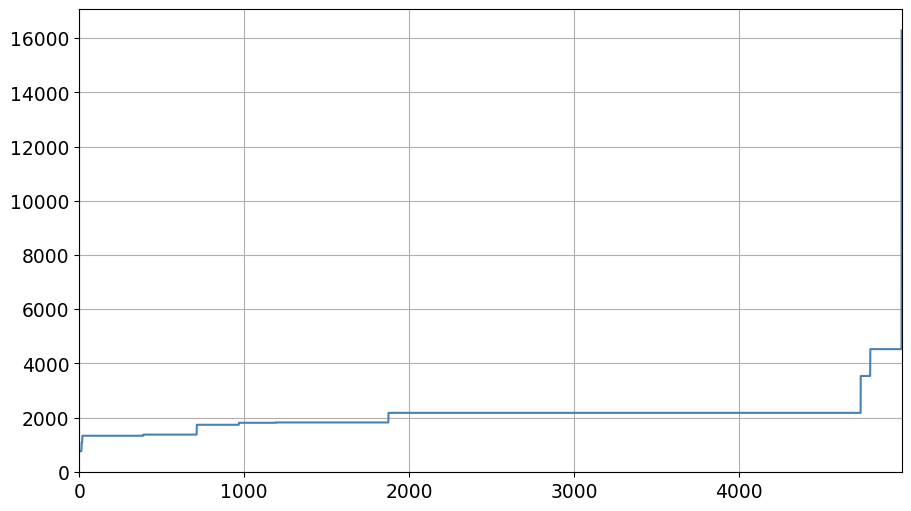

In [28]:
plot_ts(df.calibrated_ClaimSeverity_PRED.sort_values().values)

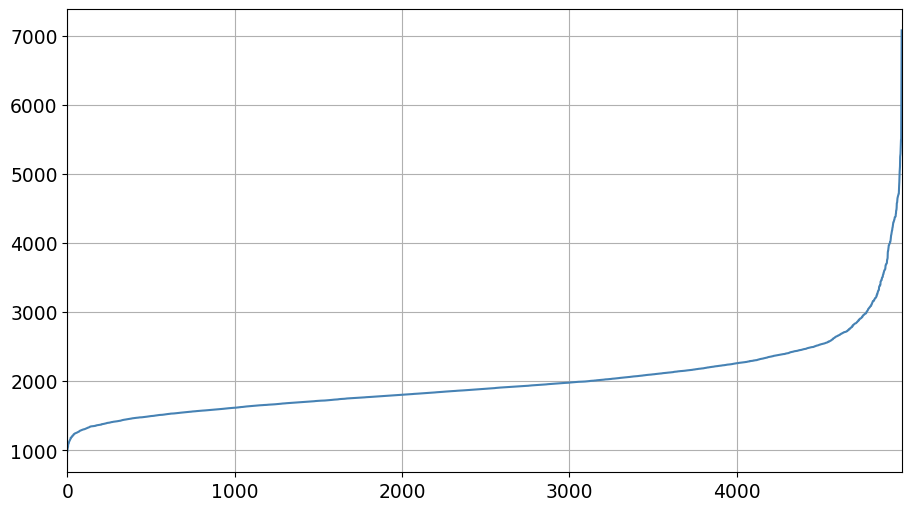

In [31]:
plot_ts(df.pure_ClaimSeverity_PRED.sort_values().values)

In [18]:
df.ClaimSeverity_TRG.reset_index()

IDpol  ClaimSeverity_TRG
0     2141337          300000.00
1     3150210          281897.49
2     3059946          208472.60
3     2202813          203172.00
4     4138268          181204.00
...       ...                ...
4982    59621               6.25
4983  1167638               5.79
4984    62913               4.60
4985  4158800               2.61
4986   175914               1.49

[4987 rows x 2 columns]

## Local GLM Calibration

In [31]:
import hashlib

def stable_str_hash(x: int, seed: str = "") -> str:
    """
    Deterministic and unique string hash for an integer input.

    Args:
        x (int): The integer to hash.
        seed (str): Optional string to introduce variability across runs.

    Returns:
        str: Hexadecimal SHA256 hash of the input.
    """
    s = f"{seed}-{x}"
    return hashlib.sha256(s.encode()).hexdigest()



def indices_ordered_values_and_hashed_index(
        s: Union[pd.Series, np.ndarray],
) -> np.ndarray:
    # Sort inputs stably by y_pred, then by hashed index
    s = pd.Series(s)
    secondary_key = s.index.to_series().apply(lambda x: stable_str_hash(x)).values
    primary_key = s.values
    sorted_indices = np.lexsort((secondary_key, primary_key))
    return sorted_indices


def ordered_by_pred_and_hashed_index(
        y_true: Union[pd.Series, np.ndarray],
        y_pred: Union[pd.Series, np.ndarray],
        sample_weight: Union[pd.Series, np.ndarray] = None
) -> Tuple[pd.Series, pd.Series, pd.Series]:
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    if sample_weight is None:
        sample_weight = pd.Series(np.ones_like(y_true), index=y_true.index)
    else:
        sample_weight = pd.Series(sample_weight)

    sorted_idx = indices_ordered_values_and_hashed_index(y_pred)

    y_true = y_true.iloc[sorted_idx].reset_index(drop=True)
    y_pred = y_pred.iloc[sorted_idx].reset_index(drop=True)
    sample_weight = sample_weight.iloc[sorted_idx].reset_index(drop=True)

    return y_true, y_pred, sample_weight


def index_ordered_by_col(
        df: pd.DataFrame,
        order_col: str,
) -> pd.Index:
    sorted_indices = indices_ordered_values_and_hashed_index(df[order_col])
    return df.index[sorted_indices]

In [145]:
from abc import ABC
from typing import Dict, Any
import numpy as np
import pandas as pd
import hyperopt as hp
from enum import Enum

from claim_modelling_kedro.pipelines.p01_init.config import Config
from claim_modelling_kedro.pipelines.p01_init.mdl_info_config import ModelEnum
from claim_modelling_kedro.pipelines.p07_data_science.model import get_sample_weight
from claim_modelling_kedro.pipelines.p08_model_calibration.calibration_model import CalibrationModel
from claim_modelling_kedro.pipelines.p07_data_science.models import StatsmodelsPoissonGLM, StatsmodelsGammaGLM, StatsmodelsTweedieGLM
# from claim_modelling_kedro.pipelines.utils.dataframes import ordered_by_pred_and_hashed_index, index_ordered_by_col
from claim_modelling_kedro.pipelines.utils.metrics import Metric


class KernelEnum(Enum):
    RECTANGULAR = "rectangular"
    GAUSSIAN = "gaussian"

def compute_kernel_weights(distances: np.ndarray, kernel: KernelEnum) -> np.ndarray:
    if kernel == KernelEnum.RECTANGULAR:
        return np.ones_like(distances)
    elif kernel == KernelEnum.GAUSSIAN:
        return np.exp(-0.5 * (distances / np.std(distances)) ** 2)
    else:
        raise ValueError(f"Unsupported kernel: {kernel}")


class LocalStatsmodelsGLMCalibration(CalibrationModel, ABC):
    def __init__(self, config: Config, model_enum: ModelEnum, kernel_enum: KernelEnum, **kwargs):
        self._model_enum = model_enum
        self._kernel_enum = kernel_enum
        CalibrationModel.__init__(self, config=config, **kwargs)

    def _fit(self, pure_predictions_df: pd.DataFrame, target_df: pd.DataFrame, **kwargs):
        sorted_idx = index_ordered_by_col(pure_predictions_df, order_col=self.pure_pred_col)
        pure_predictions_df = pure_predictions_df.loc[sorted_idx, :]
        target_df = target_df.loc[sorted_idx, :]
        sample_weight = get_sample_weight(self.config, target_df)
        sample_weight = sample_weight.loc[sorted_idx]

        self._min_pure_y = pure_predictions_df[self.pure_pred_col].min()
        self._max_pure_y = pure_predictions_df[self.pure_pred_col].max()

        self._k = int(np.ceil(self._frac * len(target_df)))
        self._y_pred = []
        self._y_pure_pred = []

        match self._model_enum:
            case ModelEnum.STATSMODELS_POISSON_GLM:
                model_class = StatsmodelsPoissonGLM
            case ModelEnum.STATSMODELS_GAMMA_GLM:
                model_class = StatsmodelsGammaGLM
            case ModelEnum.STATSMODELS_TWEEDIE_GLM:
                model_class = StatsmodelsTweedieGLM
            case _:
                raise ValueError(f"Unsupported model enum: {self._model_enum}")
        model = model_class(
            config=self.config,
            target_col=self.target_col,
            pred_col=self.pred_col,
            hparams={"fit_intercept": False, "link": "inverse"},
            call_updated_hparams=True
        )

        for i in range(len(sorted_idx)):
            center_value = pure_predictions_df[self.pure_pred_col].iloc[i]
            distances = np.abs(pure_predictions_df[self.pure_pred_col].values - center_value)
            idx = np.argsort(distances)[:self._k]
            left, right = idx.min(), idx.max() + 1

            local_target_df = target_df.iloc[left:right, :]
            local_sample_weight = sample_weight.iloc[left:right]
            local_distances = distances[left:right]
            kernel_weights = compute_kernel_weights(local_distances, self._kernel_enum)
            local_sample_weight = local_sample_weight * kernel_weights
            # GLM
            local_features_df = pd.DataFrame({"intercept": np.ones(len(local_target_df))}, index=local_target_df.index)
            model.fit(local_features_df, local_target_df, sample_weight=local_sample_weight)
            y_pred = model.predict(local_features_df[:1]).iloc[0,0]
            # Simple mean for tests
            # y_pred = np.average(local_target_df[self.target_col], weights=local_sample_weight)
            self._y_pred.append(y_pred)
            self._y_pure_pred.append(center_value)

        self._y_pred = np.array(self._y_pred)
        self._y_pure_pred = np.array(self._y_pure_pred)

    def _predict(self, pure_predictions_df: pd.DataFrame) -> pd.Series:
        y_pred = pure_predictions_df[self.pure_pred_col].values
        y_pred = np.clip(y_pred, self._min_pure_y, self._max_pure_y)
        pred = []
        for yp in y_pred:
            dist = np.abs(self._y_pure_pred - yp)
            idx = np.argsort(dist)[0]
            pred.append(self._y_pred[idx])
        return pd.Series(pred, index=pure_predictions_df.index)

    def metric(self) -> Metric:
        match self._model_enum:
            case ModelEnum.STATSMODELS_GAUSSIAN_GLM:
                return RootMeanSquaredError(self.config, pred_col=self.pred_col)
            case ModelEnum.STATSMODELS_GAMMA_GLM:
                return MeanGammaDeviance(self.config, pred_col=self.pred_col)
            case ModelEnum.STATSMODELS_POISSON_GLM:
                return MeanPoissonDeviance(self.config, pred_col=self.pred_col)
            case ModelEnum.STATSMODELS_TWEEDIE_GLM:
                return NormalizedConcentrationIndex(self.config, pred_col=self.pred_col)
            case _:
                raise ValueError(
                    f"""Family for model {self._model_enum} not supported in Stastsmodels GLM. Supported are:
            - {ModelEnum.STATSMODELS_GAUSSIAN_GLM},
            - {ModelEnum.STATSMODELS_GAMMA_GLM},
            - {ModelEnum.STATSMODELS_POISSON_GLM},
            - {ModelEnum.STATSMODELS_TWEEDIE_GLM}.""")

    def summary(self):
        return f"LocalStatsmodelsGLMCalibration: frac={self._frac}, kernel={self._kernel_enum.value}"

    def get_params(self, deep: bool = True) -> Dict[str, Any]:
        return dict(config=self.config)

    @classmethod
    def get_default_hparams(cls) -> Dict[str, Any]:
        return {
            "frac": 0.5,
        }

    @classmethod
    def get_hparams_space(cls) -> Dict[str, Any]:
        return {
            "frac": hp.uniform("frac", 0.01, 0.2),
        }

    def _updated_hparams(self):
        if self._hparams is not None:
            self._frac = float(self._hparams.get("frac"))
        self._k = None
        self._y_pred = None
        self._y_pure_pred = None
        self._min_pure_y = None
        self._max_pure_y = None


class LocalStatsmodelsGammaGLMCalibration(LocalStatsmodelsGLMCalibration):
    def __init__(self, config: Config, **kwargs):
        super().__init__(config, model_enum=ModelEnum.STATSMODELS_GAMMA_GLM, kernel_enum=KernelEnum.RECTANGULAR, **kwargs)



lglm = LocalStatsmodelsGammaGLMCalibration(config)
lglm.fit(df, df)
clb_pred = lglm.predict(df.sort_values("pure_ClaimSeverity_PRED"))
# plot_ts(clb_pred.calibrated_ClaimSeverity_PRED.values)
# plot_ts(clb_pred.calibrated_ClaimSeverity_PRED.sort_values().values)

/home/krzysiek/Development/claim-modelling-kedro/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/krzysiek/Development/claim-modelling-kedro/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/krzysiek/Development/claim-modelling-kedro/venv/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/home/krzysiek/Development/claim-modelling-kedro/venv/lib/python3.11/site-packages/statsmodels/genmod/gene

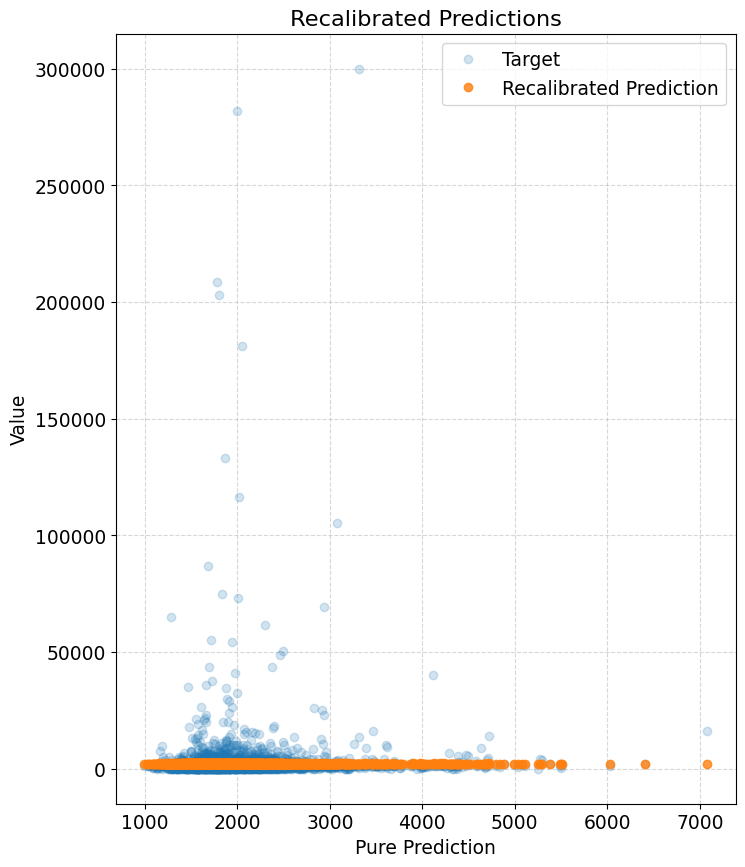

In [146]:
import matplotlib.pyplot as plt
import numpy as np

def plot_calibrated_preds_vs_pure_preds(
    y_pure_pred: Union[pd.Series, np.ndarray],
    y_pred: Union[pd.Series, np.ndarray],
    y_true: Union[pd.Series, np.ndarray] = None,
    min_val: float = -np.inf,
    max_val: float = np.inf
):
    # Ensure all inputs are numpy arrays
    y_pure_pred = np.array(y_pure_pred)
    y_pred = np.array(np.clip(y_pred, a_min=min_val, a_max=max_val))
    
    # Sort by y_pure_pred for cleaner plot
    sorted_idx = indices_ordered_values_and_hashed_index(y_pure_pred)
    y_pure_pred_sorted = y_pure_pred[sorted_idx]
    y_pred_sorted = y_pred[sorted_idx]
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 10))

    if y_true is not None:
        y_true = np.array(np.clip(y_true, a_min=min_val, a_max=max_val))
        y_true_sorted = y_true[sorted_idx]
        ax.plot(y_pure_pred_sorted, y_true_sorted, label="Target", color="tab:blue", linestyle="", marker="o", alpha=0.2)
    
    ax.plot(y_pure_pred_sorted, y_pred_sorted, label="Recalibrated Prediction", linestyle="", marker="o", color="tab:orange", alpha=0.8)
    ax.set_xlabel("Pure Prediction")
    ax.set_ylabel("Value")
    ax.set_title("Recalibrated Predictions")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.close(fig)
    return fig


plot_calibrated_preds_vs_pure_preds(y_pure_pred=df.pure_ClaimSeverity_PRED, y_pred=clb_pred.calibrated_ClaimSeverity_PRED, y_true=df.ClaimSeverity_TRG)

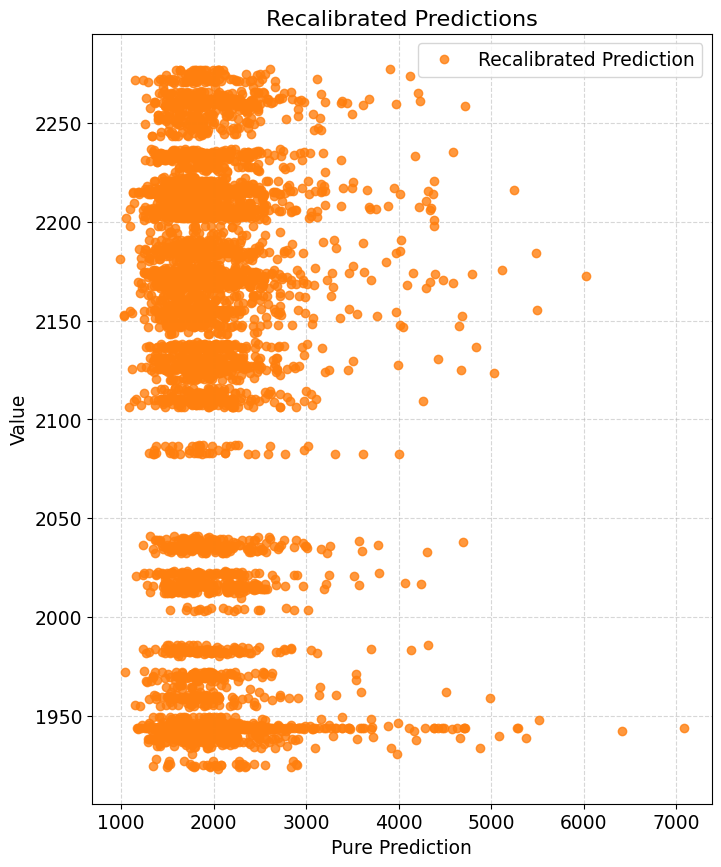

In [147]:
plot_calibrated_preds_vs_pure_preds(y_pure_pred=df.pure_ClaimSeverity_PRED, y_pred=clb_pred.calibrated_ClaimSeverity_PRED)

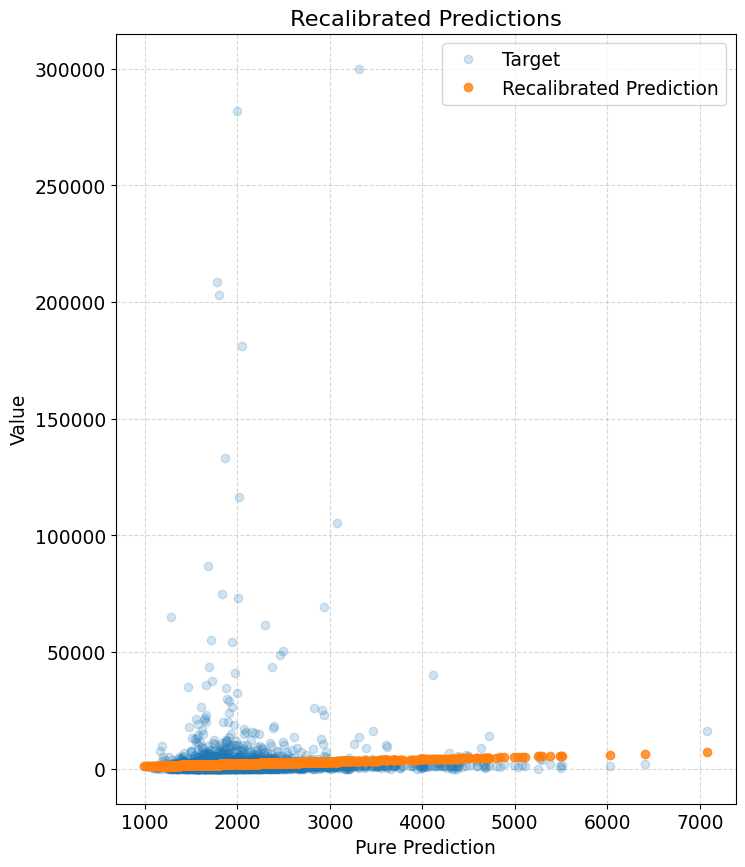

In [148]:
plot_calibrated_preds_vs_pure_preds(y_pure_pred=df.pure_ClaimSeverity_PRED, y_pred=df.pure_ClaimSeverity_PRED, y_true=df.ClaimSeverity_TRG)

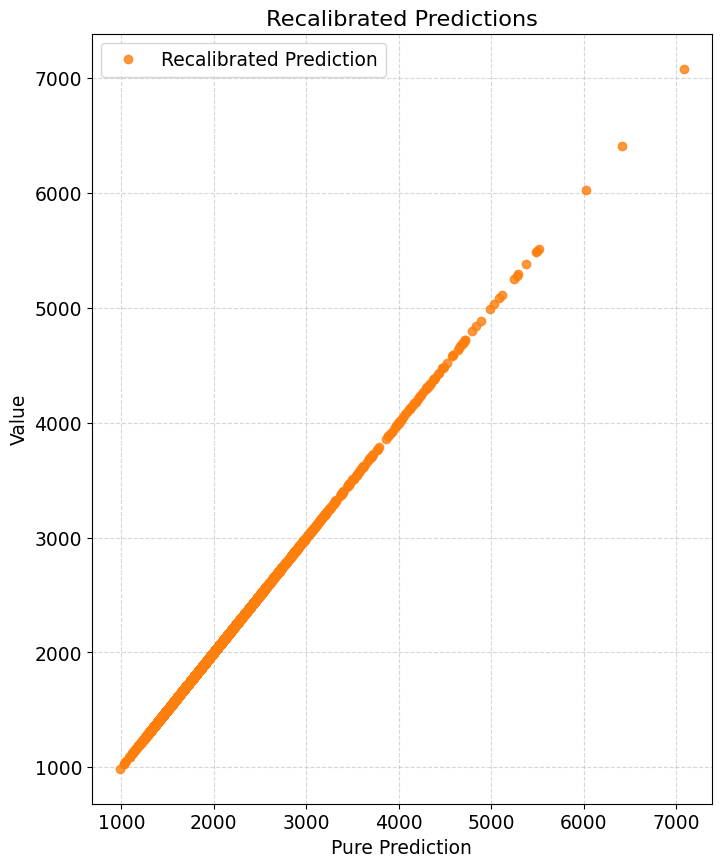

In [140]:
plot_calibrated_preds_vs_pure_preds(y_pure_pred=df.pure_ClaimSeverity_PRED, y_pred=df.pure_ClaimSeverity_PRED)

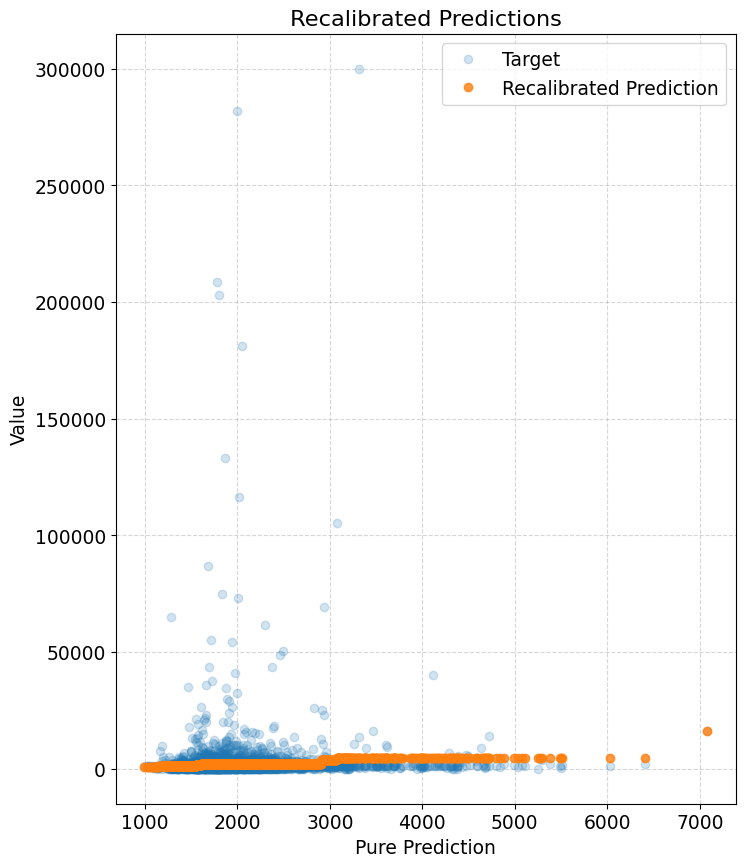

In [141]:
plot_calibrated_preds_vs_pure_preds(y_pure_pred=df.pure_ClaimSeverity_PRED, y_pred=df.ClaimSeverity_PRED, y_true=df.ClaimSeverity_TRG)

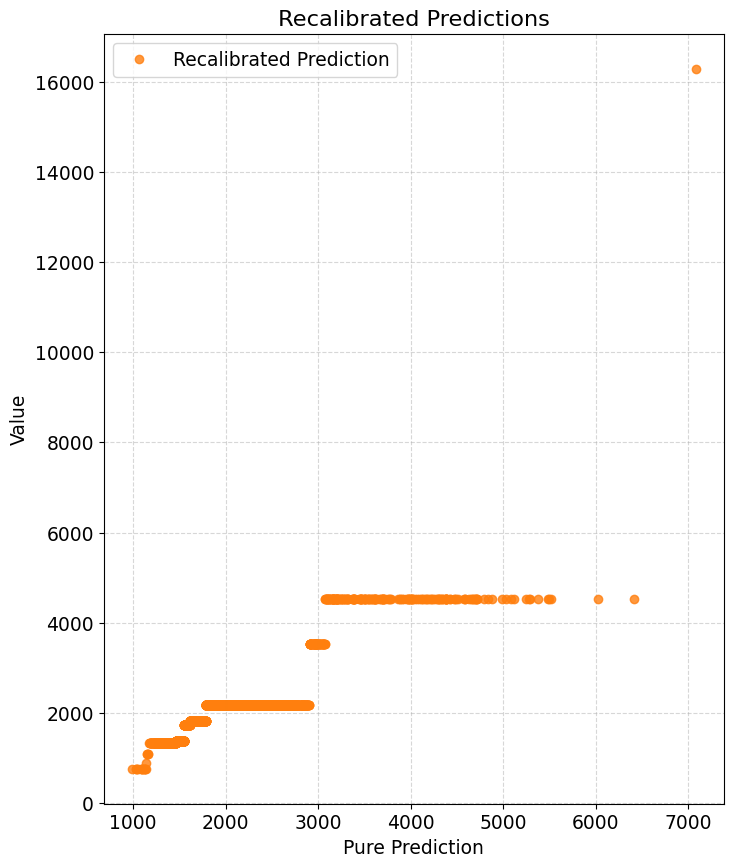

In [142]:
plot_calibrated_preds_vs_pure_preds(y_pure_pred=df.pure_ClaimSeverity_PRED, y_pred=df.ClaimSeverity_PRED)

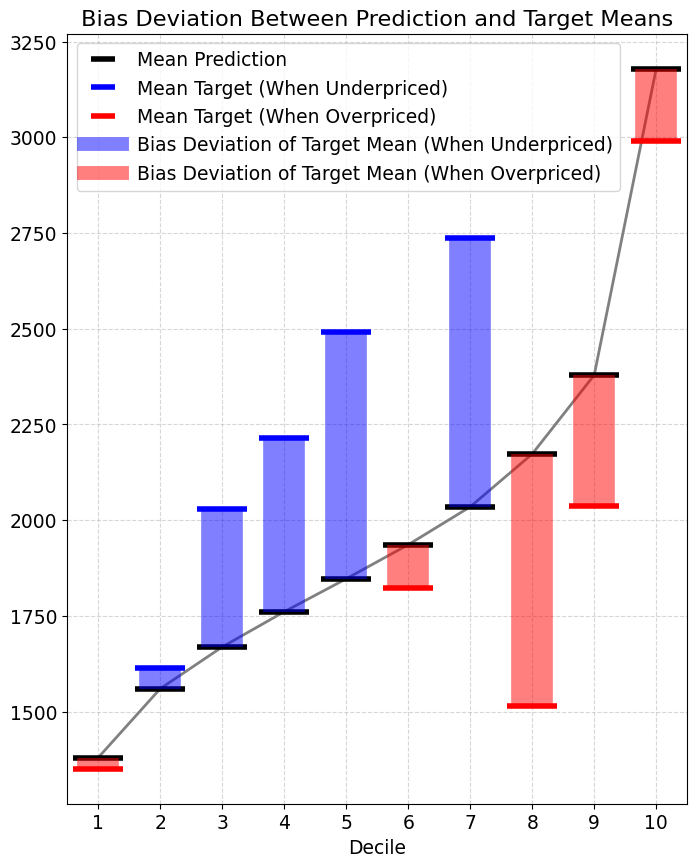

In [136]:
summary_dfs = prediction_group_summary_strict_bins(y_true=df.ClaimSeverity_TRG, y_pred = df.pure_ClaimSeverity_PRED, sample_weight=df.ClaimNb_TRG, round_precision=0, as_int=True, n_bins=10)
summary_dfs = [summary_dfs]
plot_cv_mean_deviation_lines(summary_dfs, interpolate_pred_mean=False)

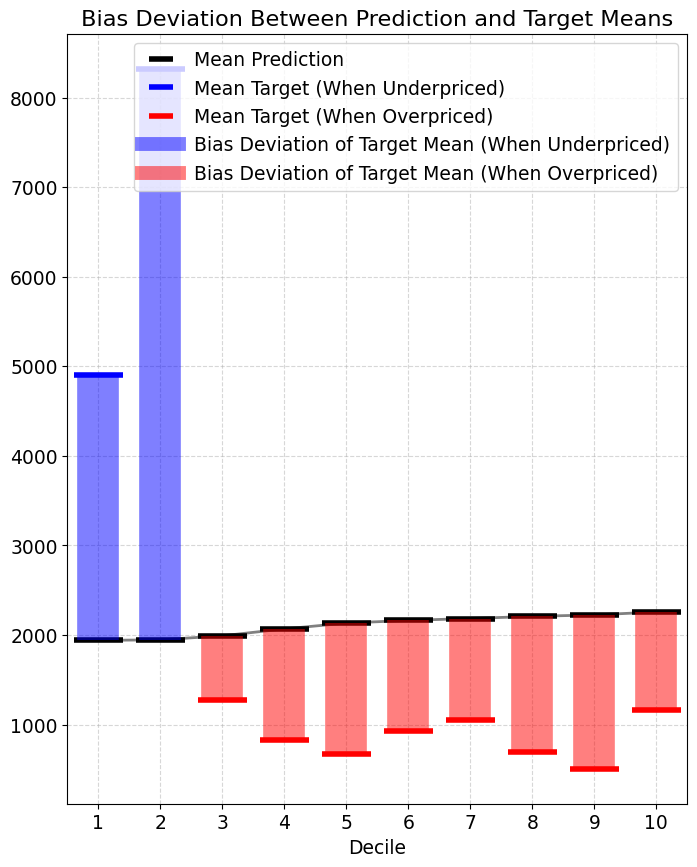

In [104]:
summary_dfs = prediction_group_summary_strict_bins(y_true=df.ClaimSeverity_TRG, y_pred = clb_pred.calibrated_ClaimSeverity_PRED, sample_weight=df.ClaimNb_TRG, round_precision=0, as_int=True, n_bins=10)
summary_dfs = [summary_dfs]
plot_cv_mean_deviation_lines(summary_dfs, interpolate_pred_mean=False)

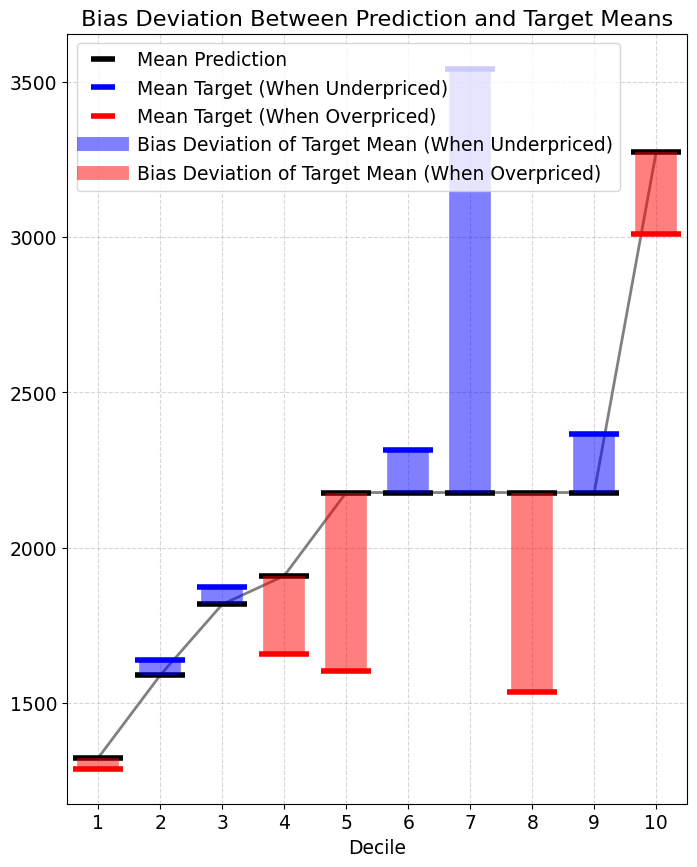

In [75]:
summary_dfs = prediction_group_summary_strict_bins(y_true=df.ClaimSeverity_TRG, y_pred = df.ClaimSeverity_PRED, sample_weight=df.ClaimNb_TRG, round_precision=0, as_int=True, n_bins=10)
summary_dfs = [summary_dfs]
plot_cv_mean_deviation_lines(summary_dfs, interpolate_pred_mean=False)